# Packages

In [12]:
pip install deephit

In [13]:
pip install lifelines

In [14]:
import random
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#import dataframe_image as dfi
from lifelines import KaplanMeierFitter 
from lifelines.statistics import (logrank_test, 
                                  pairwise_logrank_test, 
                                  multivariate_logrank_test, 
                                  survival_difference_at_fixed_point_in_time_test)
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi
import lifelines
from sklearn.model_selection import train_test_split
plt.style.use('seaborn')
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index
#import import_data as impt

#from deephit import *

# DeepHit

In [15]:
import numpy as np
import pandas as pd
# import tensorflow as tf
import random
import os

from sklearn.model_selection import train_test_split

#import import_data as impt

from deephit import *


In [16]:
import random 
import datetime
import importlib
import math

from lifelines import KaplanMeierFitter 
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
from termcolor import colored
from scipy import stats
import pickle as pkl
import tensorflow as tf 
#from tensorflow.contrib.layers import fully_connected as FC_Net 
from sklearn.preprocessing import LabelEncoder
#from sklearn.metrics import brier_score_loss, train_test_split,  roc_auc_score
#from sklearn.model_selection import  
#from sklearn.metrics import
#import sklearn.metrics as metrics

'''
This declare DeepHit architecture:

INPUTS:
    - input_dims: dictionary of dimension information
        > x_dim: dimension of features
        > num_Event: number of competing events (this does not include censoring label)
        > num_Category: dimension of time horizon of interest, i.e., |T| where T = {0, 1, ..., T_max-1}
                      : this is equivalent to the output dimension
    - network_settings:
        > h_dim_shared & num_layers_shared: number of nodes and number of fully-connected layers for the shared subnetwork
        > h_dim_CS & num_layers_CS: number of nodes and number of fully-connected layers for the cause-specific subnetworks
        > active_fn: 'relu', 'elu', 'tanh'
        > initial_W: Xavier initialization is used as a baseline

LOSS FUNCTIONS:
    - 1. loglikelihood (this includes log-likelihood of subjects who are censored)
    - 2. rankding loss (this is calculated only for acceptable pairs; see the paper for the definition)
    - 3. calibration loss (this is to reduce the calibration loss; this is not included in the paper version)
'''

     
global _EPSILON
_EPSILON = 1e-08

### MASK FUNCTIONS
'''
    fc_mask2      : To calculate LOSS_1 (log-likelihood loss)
    fc_mask3      : To calculate LOSS_2 (ranking loss)
'''
def impt_f_get_fc_mask2(time, label, num_Event, num_Category):
    '''
        mask4 is required to get the log-likelihood loss
        mask4 size is [N, num_Event, num_Category]
            if not censored : one element = 1 (0 elsewhere)
            if censored     : fill elements with 1 after the censoring time (for all events)
    '''
    #print('impt_f_get_fc_mask2')
    mask = np.zeros([np.shape(time)[0], num_Event, num_Category]) # for the first loss function
    for i in range(np.shape(time)[0]):
        if label[i,0] != 0:  #not censored
            mask[i,int(label[i,0]-1),int(time[i,0])] = 1
        else: #label[i,2]==0: censored
            mask[i,:,int(time[i,0]+1):] =  1 #fill 1 until from the censoring time (to get 1 - \sum F)
    return mask


def impt_f_get_fc_mask3(time, meas_time, num_Category):
    '''
        mask5 is required calculate the ranking loss (for pair-wise comparision)
        mask5 size is [N, num_Category].
        - For longitudinal measurements:
             1's from the last measurement to the event time (exclusive and inclusive, respectively)
             denom is not needed since comparing is done over the same denom
        - For single measurement:
             1's from start to the event time(inclusive)
    '''
    # print('impt_f_get_fc_mask3')
    mask = np.zeros([np.shape(time)[0], num_Category]) # for the first loss function
    if np.shape(meas_time):  #lonogitudinal measurements
        for i in range(np.shape(time)[0]):
            t1 = int(meas_time[i, 0]) # last measurement time
            t2 = int(time[i, 0]) # censoring/event time
            mask[i,(t1+1):(t2+1)] = 1  #this excludes the last measurement time and includes the event time
    else:                    #single measurement
        for i in range(np.shape(time)[0]):
            t = int(time[i, 0]) # censoring/event time
            mask[i,:(t+1)] = 1  #this excludes the last measurement time and includes the event time
    return mask

# los function
########## ADAPTED IMPORT FOR LOS
def get_Normalization_los(dffeatures, data_stats): # only implemented standard, but can include max-min type in the future
    # print('get_Normalization_los')
    data=dffeatures
    for feat in dffeatures.columns:
        if data_stats.loc[feat,'std'] !=0:
            data[feat]=(dffeatures[feat] - data_stats.loc[feat,'mean'])/data_stats.loc[feat,'std']
        else:
            data[feat]=(dffeatures[feat] - data_stats.loc[feat,'mean'])
    return np.asarray(data)


def import_dataset_los_old(dflabel,dfval,dffeatures,data_stats,num_Category,num_Event,x_dim):
    # print('import_dataset_los')
    label           = np.asarray(dflabel)
    time            = np.asarray(dfval)
    data            = get_Normalization_los(dffeatures,data_stats)
    mask1           = impt_f_get_fc_mask2(time, label, num_Event, num_Category)
    mask2           = impt_f_get_fc_mask3(time, -1, num_Category)
    DIM             = (x_dim)
    DATA            = (data, time, label)
    MASK            = (mask1, mask2)
    
    return DIM, DATA, MASK

def import_dataset_los(dffeatures,data_stats,num_Category,num_Event,x_dim):
    label           = np.asarray([[1]]) # arbitrary, adaptation for pred.
    time            = np.asarray([[700]])
    data            = get_Normalization_los(dffeatures,data_stats)
    mask1           = impt_f_get_fc_mask2(time, label, num_Event, num_Category)
    mask2           = impt_f_get_fc_mask3(time, -1, num_Category)
    MASK            = (mask1, mask2)

    return data, MASK
def test(x):
    print('x = ', x)


##### USER-DEFINED FUNCTIONS
def log(x):
    #print('logX')
    #tf.log is deprecated. Please use tf.math.log instead.
    return tf.math.log(x + _EPSILON)

def div(x, y):
    #print('divXY')
    return tf.div(x, (y + _EPSILON))

def load_dffromCsv(dfname):
    dir='/dbfs/user/hive/warehouse/'
    df=pd.read_csv(dir+dfname)
    print(dfname, 'loaded!')
    return df

def save_dftoCsv(df, dfname):
    dir='/dbfs/user/hive/warehouse/'
    df.to_csv(dir+dfname, index = False)
    print(dfname, 'saved!')


class Model_DeepHit:
    def __init__(self, sess, name, input_dims, network_settings):
        self.sess               = sess
        self.name               = name

        # INPUT DIMENSIONS
        self.x_dim              = input_dims['x_dim']

        self.num_Event          = input_dims['num_Event']
        self.num_Category       = input_dims['num_Category']

        # NETWORK HYPER-PARMETERS
        self.h_dim_shared       = network_settings['h_dim_shared']
        self.h_dim_CS           = network_settings['h_dim_CS']
        self.num_layers_shared  = network_settings['num_layers_shared']
        self.num_layers_CS      = network_settings['num_layers_CS']

        self.active_fn          = network_settings['active_fn']
        self.initial_W          = network_settings['initial_W']
        self.reg_W              = tf.contrib.layers.l2_regularizer(scale=1.0)
        self.reg_W_out          = tf.contrib.layers.l1_regularizer(scale=1.0)

        self._build_net()


    def _build_net(self):
        with tf.variable_scope(self.name):
            #### PLACEHOLDER DECLARATION
            #The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.
            self.mb_size     = tf.compat.v1.placeholder(tf.int32, [], name='batch_size')
            self.lr_rate     = tf.compat.v1.placeholder(tf.float32, [], name='learning_rate')
            self.keep_prob   = tf.compat.v1.placeholder(tf.float32, [], name='keep_probability')   #keeping rate
            self.a           = tf.compat.v1.placeholder(tf.float32, [], name='alpha')
            self.b           = tf.compat.v1.placeholder(tf.float32, [], name='beta')

            self.x           = tf.compat.v1.placeholder(tf.float32, shape=[None, self.x_dim], name='inputs')
            self.k           = tf.compat.v1.placeholder(tf.float32, shape=[None, 1], name='labels')     #event/censoring label (censoring:0)
            self.t           = tf.compat.v1.placeholder(tf.float32, shape=[None, 1], name='timetoevents')

            self.fc_mask1    = tf.compat.v1.placeholder(tf.float32, shape=[None, self.num_Event, self.num_Category], name='mask1')  #for Loss 1
            self.fc_mask2    = tf.compat.v1.placeholder(tf.float32, shape=[None, self.num_Category], name='mask2')  #for Loss 2 / Loss 3


            ##### SHARED SUBNETWORK w/ FCNETS
            shared_out = utils_create_FCNet(self.x, self.num_layers_shared, self.h_dim_shared, self.active_fn, self.h_dim_shared, self.active_fn, self.initial_W, self.keep_prob, self.reg_W)
            last_x = self.x  #for residual connection

            h = tf.concat([last_x, shared_out], axis=1)

            #(num_layers_CS) layers for cause-specific (num_Event subNets)
            out = []
            for _ in range(self.num_Event):
                cs_out = utils_create_FCNet(h, (self.num_layers_CS), self.h_dim_CS, self.active_fn, self.h_dim_CS, self.active_fn, self.initial_W, self.keep_prob, self.reg_W)
                out.append(cs_out)
            out = tf.stack(out, axis=1) # stack referenced on subject
            out = tf.reshape(out, [-1, self.num_Event*self.h_dim_CS])
            out = tf.nn.dropout(out, keep_prob=self.keep_prob)

            out = FC_Net(out, self.num_Event * self.num_Category, activation_fn=tf.nn.softmax, 
                         weights_initializer=self.initial_W, weights_regularizer=self.reg_W_out, scope="Output")
            self.out = tf.reshape(out, [-1, self.num_Event, self.num_Category])


            ##### GET LOSS FUNCTIONS
            self.loss_Log_Likelihood()      #get loss1: Log-Likelihood loss
            self.loss_Ranking()        




            self.LOSS_TOTAL = self.a*self.LOSS_1 + self.b*self.LOSS_2   ## diff from original
            #tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.
            self.solver =  tf.compat.v1.train.AdamOptimizer(learning_rate=self.lr_rate).minimize(self.LOSS_TOTAL)


    ### LOSS-FUNCTION 1 -- Log-likelihood loss
    def loss_Log_Likelihood(self):
        I_1 = tf.sign(self.k)

        #for uncenosred: log P(T=t,K=k|x)
        #keep_dims is deprecated, use keepdims instead
        tmp1 = tf.reduce_sum(tf.reduce_sum(self.fc_mask1 * self.out, reduction_indices=2), reduction_indices=1, keepdims=True)
        tmp1 = I_1 * log(tmp1)

        #for censored: log \sum P(T>t|x)
        tmp2 = tf.reduce_sum(tf.reduce_sum(self.fc_mask1 * self.out, reduction_indices=2), reduction_indices=1, keepdims=True)
        tmp2 = (1. - I_1) * log(tmp2)

        self.LOSS_1 = - tf.reduce_mean(tmp1 + 1.0*tmp2)


    ### LOSS-FUNCTION 2 -- Ranking loss
    def loss_Ranking(self):
        #x        sigma1 = tf.constant(0.1, dtype=tf.float32)
        #x        sigma1 = tf.constant(0.65, dtype=tf.float32)
        
        sigma1 = tf.constant(0.65, dtype=tf.float32)
        eta = []
        #tf.diag is deprecated. Please use tf.linalg.tensor_diag instead.
        #tf.diag_part is deprecated. Please use tf.linalg.tensor_diag_part instead.
        for e in range(self.num_Event):
            one_vector = tf.ones_like(self.t, dtype=tf.float32)
            I_2 = tf.cast(tf.equal(self.k, e+1), dtype = tf.float32) #indicator for event
            I_2 = tf.linalg.tensor_diag(tf.squeeze(I_2))
            tmp_e = tf.reshape(tf.slice(self.out, [0, e, 0], [-1, 1, -1]), [-1, self.num_Category]) #event specific joint prob.

            R = tf.matmul(tmp_e, tf.transpose(self.fc_mask2)) #no need to divide by each individual dominator
            # r_{ij} = risk of i-th pat based on j-th time-condition (last meas. time ~ event time) , i.e. r_i(T_{j})

            diag_R = tf.reshape(tf.linalg.tensor_diag_part(R), [-1, 1])
            R = tf.matmul(one_vector, tf.transpose(diag_R)) - R # R_{ij} = r_{j}(T_{j}) - r_{i}(T_{j})
            R = tf.transpose(R)                                 # Now, R_{ij} (i-th row j-th column) = r_{i}(T_{i}) - r_{j}(T_{i})

            T = tf.nn.relu(tf.sign(tf.matmul(one_vector, tf.transpose(self.t)) - tf.matmul(self.t, tf.transpose(one_vector))))
            # T_{ij}=1 if t_i < t_j  and T_{ij}=0 if t_i >= t_j

            T = tf.matmul(I_2, T) # only remains T_{ij}=1 when event occured for subject i
            #keep_dims is deprecated, use keepdims instead
            tmp_eta = tf.reduce_mean(T * tf.exp(-R/sigma1), reduction_indices=1, keepdims=True)

            eta.append(tmp_eta)
        eta = tf.stack(eta, axis=1) #stack referenced on subjects
        eta = tf.reduce_mean(tf.reshape(eta, [-1, self.num_Event]), reduction_indices=1, keepdims=True)

        self.LOSS_2 = tf.reduce_sum(eta) #sum over num_Events



    
    def get_cost(self, DATA, MASK, PARAMETERS, keep_prob, lr_train):
        (x_mb, k_mb, t_mb) = DATA
        (m1_mb, m2_mb) = MASK
        (alpha, beta) = PARAMETERS
        return self.sess.run(self.LOSS_TOTAL, 
                             feed_dict={self.x:x_mb, self.k:k_mb, self.t:t_mb, self.fc_mask1: m1_mb, self.fc_mask2:m2_mb, 
                                        self.a:alpha, self.b:beta,
                                        self.mb_size: np.shape(x_mb)[0], self.keep_prob:keep_prob, self.lr_rate:lr_train})

    def train(self, DATA, MASK, PARAMETERS, keep_prob, lr_train):
        (x_mb, k_mb, t_mb) = DATA
        (m1_mb, m2_mb) = MASK
        (alpha, beta) = PARAMETERS
        return self.sess.run([self.solver, self.LOSS_TOTAL], 
                             feed_dict={self.x:x_mb, self.k:k_mb, self.t:t_mb, self.fc_mask1: m1_mb, self.fc_mask2:m2_mb, 
                                        self.a:alpha, self.b:beta,
                                        self.mb_size: np.shape(x_mb)[0], self.keep_prob:keep_prob, self.lr_rate:lr_train})
    
    def predict(self, x_test, keep_prob=1.0):
        return self.sess.run(self.out, feed_dict={self.x: x_test, self.mb_size: np.shape(x_test)[0], self.keep_prob: keep_prob})

    # def predict(self, x_test, MASK, keep_prob=1.0):
    #     (m1_test, m2_test) = MASK
    #     return self.sess.run(self.out, 
    #                          feed_dict={self.x: x_test, self.rnn_mask1:m1_test, self.rnn_mask2:m2_test, self.keep_prob: keep_prob})
###utility network


### EXTRACT STATE OUTPUT OF MULTICELL-RNNS
def utils_create_concat_state(state, num_layers, RNN_type):
    '''
        GOAL	     : concatenate the tuple-type tensor (state) into a single tensor
        state        : input state is a tuple ofo MulticellRNN (i.e. output of MulticellRNN)
                       consist of only hidden states h for GRU and hidden states c and h for LSTM
        num_layers   : number of layers in MulticellRNN
        RNN_type     : either 'LSTM' or 'GRU'
    '''
    for i in range(num_layers):
        if RNN_type == 'LSTM':
            tmp = state[i][1] ## i-th layer, h state for LSTM
        elif RNN_type == 'GRU':
            tmp = state[i] ## i-th layer, h state for GRU
        else:
            print('ERROR: WRONG RNN CELL TYPE')

        if i == 0:
            rnn_state_out = tmp
        else:
            rnn_state_out = tf.concat([rnn_state_out, tmp], axis = 1)
    
    return rnn_state_out


### FEEDFORWARD NETWORK
def utils_create_FCNet(inputs, num_layers, h_dim, h_fn, o_dim, o_fn, w_init, keep_prob=1.0, w_reg=None):
    '''
        GOAL             : Create FC network with different specifications 
        inputs (tensor)  : input tensor
        num_layers       : number of layers in FCNet
        h_dim  (int)     : number of hidden units
        h_fn             : activation function for hidden layers (default: tf.nn.relu)
        o_dim  (int)     : number of output units
        o_fn             : activation function for output layers (defalut: None)
        w_init           : initialization for weight matrix (defalut: Xavier)
        keep_prob        : keep probabilty [0, 1]  (if None, dropout is not employed)
    '''
    # default active functions (hidden: relu, out: None)
    if h_fn is None:
        h_fn = tf.nn.relu
    if o_fn is None:
        o_fn = None

    # default initialization functions (weight: Xavier, bias: None)
    if w_init is None:
        w_init = tf.contrib.layers.xavier_initializer() # Xavier initialization

    for layer in range(num_layers):
        if num_layers == 1:
            out = FC_Net(inputs, o_dim, activation_fn=o_fn, weights_initializer=w_init, weights_regularizer=w_reg)
        else:
            if layer == 0:
                h = FC_Net(inputs, h_dim, activation_fn=h_fn, weights_initializer=w_init, weights_regularizer=w_reg)
                if not keep_prob is None:
                    h = tf.nn.dropout(h, keep_prob=keep_prob)

            elif layer > 0 and layer != (num_layers-1): # layer > 0:
                h = FC_Net(h, h_dim, activation_fn=h_fn, weights_initializer=w_init, weights_regularizer=w_reg)
                if not keep_prob is None:
                    h = tf.nn.dropout(h, keep_prob=keep_prob)

            else: # layer == num_layers-1 (the last layer)
                out = FC_Net(h, o_dim, activation_fn=o_fn, weights_initializer=w_init, weights_regularizer=w_reg)

    return out
'''
This provide time-dependent Concordance index and Brier Score:
    - Use weighted_c_index and weighted_brier_score, which are the unbiased estimates.
    
See equations and descriptions eq. (11) and (12) of the following paper:
    - C. Lee, W. R. Zame, A. Alaa, M. van der Schaar, "Temporal Quilting for Survival Analysis", AISTATS 2019
'''


### C(t)-INDEX CALCULATION
def c_index(Prediction, Time_survival, Death, Time):
    '''
        This is a cause-specific c(t)-index
        - Prediction      : risk at Time (higher --> more risky)
        - Time_survival   : survival/censoring time
        - Death           :
            > 1: death
            > 0: censored (including death from other cause)
        - Time            : time of evaluation (time-horizon when evaluating C-index)
    '''
    N = len(Prediction)
    A = np.zeros((N,N))
    Q = np.zeros((N,N))
    N_t = np.zeros((N,N))
    Num = 0
    Den = 0
    for i in range(N):
        A[i, np.where(Time_survival[i] < Time_survival)] = 1
        Q[i, np.where(Prediction[i] > Prediction)] = 1
  
        if (Time_survival[i]<=Time and Death[i]==1):
            N_t[i,:] = 1

    Num  = np.sum(((A)*N_t)*Q)
    Den  = np.sum((A)*N_t)

    if Num == 0 and Den == 0:
        result = -1 # not able to compute c-index!
    else:
        result = float(Num/Den)

    return result

### BRIER-SCORE
def brier_score(Prediction, Time_survival, Death, Time):
    N = len(Prediction)
    y_true = ((Time_survival <= Time) * Death).astype(float)

    return np.mean((Prediction - y_true)**2)

    # result2[k, t] = brier_score_loss(risk[:, k], ((te_time[:,0] <= eval_horizon) * (te_label[:,0] == k+1)).astype(int))


##### WEIGHTED C-INDEX & BRIER-SCORE
def CensoringProb(Y, T):

    T = T.reshape([-1]) # (N,) - np array
    Y = Y.reshape([-1]) # (N,) - np array

    kmf = KaplanMeierFitter()
    kmf.fit(T, event_observed=(Y==0).astype(int))  # censoring prob = survival probability of event "censoring"
    G = np.asarray(kmf.survival_function_.reset_index()).transpose()
    G[1, G[1, :] == 0] = G[1, G[1, :] != 0][-1]  #fill 0 with ZoH (to prevent nan values)
    
    return G


### C(t)-INDEX CALCULATION: this account for the weighted average for unbaised estimation
def weighted_c_index(T_train, Y_train, Prediction, T_test, Y_test, Time):
    '''
        Thi6@gmail.coms is a cause-specific c(t)-index
        - Prediction      : risk at Time (higher --> more risky)
        - Time_survival   : survival/censoring time
        - Death           :
            > 1: death
            > 0: censored (including death from other cause)
        - Time            : time of evaluation (time-horizon when evaluating C-index)
    '''
    G = CensoringProb(Y_train, T_train)

    N = len(Prediction)
    A = np.zeros((N,N))
    Q = np.zeros((N,N))
    N_t = np.zeros((N,N))
    Num = 0
    Den = 0
    for i in range(N):
        tmp_idx = np.where(G[0,:] >= T_test[i])[0]

        if len(tmp_idx) == 0:
            W = (1./G[1, -1])**2
        else:
            W = (1./G[1, tmp_idx[0]])**2

        A[i, np.where(T_test[i] < T_test)] = 1. * W
        Q[i, np.where(Prediction[i] > Prediction)] = 1. # give weights

        if (T_test[i]<=Time and Y_test[i]==1):
            N_t[i,:] = 1.

    Num  = np.sum(((A)*N_t)*Q)
    Den  = np.sum((A)*N_t)

    if Num == 0 and Den == 0:
        result = -1 # not able to compute c-index!
    else:
        result = float(Num/Den)

    return result


# this account for the weighted average for unbaised estimation
def weighted_brier_score(T_train, Y_train, Prediction, T_test, Y_test, Time):
    G = CensoringProb(Y_train, T_train)
    N = len(Prediction)

    W = np.zeros(len(Y_test))
    Y_tilde = (T_test > Time).astype(float)

    for i in range(N):
        tmp_idx1 = np.where(G[0,:] >= T_test[i])[0]
        tmp_idx2 = np.where(G[0,:] >= Time)[0]

        if len(tmp_idx1) == 0:
            G1 = G[1, -1]
        else:
            G1 = G[1, tmp_idx1[0]]

        if len(tmp_idx2) == 0:
            G2 = G[1, -1]
        else:
            G2 = G[1, tmp_idx2[0]]
        W[i] = (1. - Y_tilde[i])*float(Y_test[i])/G1 + Y_tilde[i]/G2

    y_true = ((T_test <= Time) * Y_test).astype(float)

    return np.mean(W*(Y_tilde - (1.-Prediction))**2)
'''
This provide the dimension/data/mask to train/test the network.

Once must construct a function similar to "import_dataset_SYNTHETIC":
    - DATA FORMAT:
        > data: covariates with x_dim dimension.
        > label: 0: censoring, 1 ~ K: K competing(single) risk(s)
        > time: time-to-event or time-to-censoring
    - Based on the data, creat mask1 and mask2 that are required to calculate loss functions.
'''

    
### random with replace minibatches function    
def f_get_minibatch(mb_size, x, label, time, mask1, mask2):
    idx = range(np.shape(x)[0])
    idx = random.sample(idx, mb_size)

    x_mb = x[idx, :].astype(np.float32)
    k_mb = label[idx, :].astype(np.float32) # censoring(0)/event(1,2,..) label
    t_mb = time[idx, :].astype(np.float32)
    m1_mb = mask1[idx, :, :].astype(np.float32) #fc_mask
    m2_mb = mask2[idx, :].astype(np.float32) #fc_mask
    return x_mb, k_mb, t_mb, m1_mb, m2_mb

def xbatchpredict(xdata,xfunc, n=10000):
    xlength = len(xdata)
    print("BatchSubmitPrediction, total size= " + str(xlength))
    for xindex in range (0, xlength, n):
        x_pred_xindex = xfunc(xdata[xindex: xindex + n, :])
        if xindex == 0:
            pred_x = x_pred_xindex
        else:
            pred_x = np.concatenate((pred_x, x_pred_xindex), axis=0)
            print(np.shape(pred_x))
    return pred_x 

def restoreModel(data, input_dims, network_settings,model_path):
    pred=None
    tf.compat.v1.reset_default_graph()
    try:    
        config = tf.compat.v1.ConfigProto()
        config.gpu_options.allow_growth = True
        with tf.Session() as sess:
            #print('sess:', sess)
            model2 = Model_DeepHit(sess, "DeepHit", input_dims, network_settings)
            ##print('restored..')
            saver = tf.compat.v1.train.Saver()
            saver.restore(sess, model_path)
            pred = model2.predict(data)
            #print('pred=',pred)
    except Exception as e:
            print('error:', e)
    return pred
  
def final_prediction(pred):
      categorization=None
      if pred is None:
        return 'N/A', 'N/A'
      else:
            pred1 = pred[:,0,:]
            pred2 = pred[:,1,:]
            pred3 = pred1 + pred2

            predlosmean = np.multiply(pred3, np.arange(1,pred3.shape[1]+1,1))
            xlos=predlosmean.cumsum(axis=1)[:,pred3.shape[1]-1]
            categorization=0,1,2,-99

      return xlos, categorization 



In [17]:
'''
This provide time-dependent Concordance index and Brier Score:
    - Use weighted_c_index and weighted_brier_score, which are the unbiased estimates.
    
See equations and descriptions eq. (11) and (12) of the following paper:
    - C. Lee, W. R. Zame, A. Alaa, M. van der Schaar, "Temporal Quilting for Survival Analysis", AISTATS 2019
'''

import numpy as np
from lifelines import KaplanMeierFitter


### C(t)-INDEX CALCULATION
def c_index(Prediction, Time_survival, Death, Time):
    '''
        This is a cause-specific c(t)-index
        - Prediction      : risk at Time (higher --> more risky)
        - Time_survival   : survival/censoring time
        - Death           :
            > 1: death
            > 0: censored (including death from other cause)
        - Time            : time of evaluation (time-horizon when evaluating C-index)
    '''
    N = len(Prediction)
    A = np.zeros((N,N))
    Q = np.zeros((N,N))
    N_t = np.zeros((N,N))
    Num = 0
    Den = 0
    for i in range(N):
        A[i, np.where(Time_survival[i] < Time_survival)] = 1
        Q[i, np.where(Prediction[i] > Prediction)] = 1
  
        if (Time_survival[i]<=Time and Death[i]==1):
            N_t[i,:] = 1

    Num  = np.sum(((A)*N_t)*Q)
    Den  = np.sum((A)*N_t)

    if Num == 0 and Den == 0:
        result = -1 # not able to compute c-index!
    else:
        result = float(Num/Den)

    return result

### BRIER-SCORE
def brier_score(Prediction, Time_survival, Death, Time):
    N = len(Prediction)
    y_true = ((Time_survival <= Time) * Death).astype(float)

    return np.mean((Prediction - y_true)**2)

    # result2[k, t] = brier_score_loss(risk[:, k], ((te_time[:,0] <= eval_horizon) * (te_label[:,0] == k+1)).astype(int))


##### WEIGHTED C-INDEX & BRIER-SCORE
def CensoringProb(Y, T):

    T = T.reshape([-1]) # (N,) - np array
    Y = Y.reshape([-1]) # (N,) - np array

    kmf = KaplanMeierFitter()
    kmf.fit(T, event_observed=(Y==0).astype(int))  # censoring prob = survival probability of event "censoring"
    G = np.asarray(kmf.survival_function_.reset_index()).transpose()
    G[1, G[1, :] == 0] = G[1, G[1, :] != 0][-1]  #fill 0 with ZoH (to prevent nan values)
    
    return G


### C(t)-INDEX CALCULATION: this account for the weighted average for unbaised estimation
def weighted_c_index(T_train, Y_train, Prediction, T_test, Y_test, Time):
    '''
        This is a cause-specific c(t)-index
        - Prediction      : risk at Time (higher --> more risky)
        - Time_survival   : survival/censoring time
        - Death           :
            > 1: death
            > 0: censored (including death from other cause)
        - Time            : time of evaluation (time-horizon when evaluating C-index)
    '''
    G = CensoringProb(Y_train, T_train)

    N = len(Prediction)
    A = np.zeros((N,N))
    Q = np.zeros((N,N))
    N_t = np.zeros((N,N))
    Num = 0
    Den = 0
    for i in range(N):
        tmp_idx = np.where(G[0,:] >= T_test[i])[0]

        if len(tmp_idx) == 0:
            W = (1./G[1, -1])**2
        else:
            W = (1./G[1, tmp_idx[0]])**2

        A[i, np.where(T_test[i] < T_test)] = 1. * W
        Q[i, np.where(Prediction[i] > Prediction)] = 1. # give weights

        if (T_test[i]<=Time and Y_test[i]==1):
            N_t[i,:] = 1.

    Num  = np.sum(((A)*N_t)*Q)
    Den  = np.sum((A)*N_t)

    if Num == 0 and Den == 0:
        result = -1 # not able to compute c-index!
    else:
        result = float(Num/Den)

    return result


# this account for the weighted average for unbaised estimation
def weighted_brier_score(T_train, Y_train, Prediction, T_test, Y_test, Time):
    G = CensoringProb(Y_train, T_train)
    N = len(Prediction)

    W = np.zeros(len(Y_test))
    Y_tilde = (T_test > Time).astype(float)

    for i in range(N):
        tmp_idx1 = np.where(G[0,:] >= T_test[i])[0]
        tmp_idx2 = np.where(G[0,:] >= Time)[0]

        if len(tmp_idx1) == 0:
            G1 = G[1, -1]
        else:
            G1 = G[1, tmp_idx1[0]]

        if len(tmp_idx2) == 0:
            G2 = G[1, -1]
        else:
            G2 = G[1, tmp_idx2[0]]
        W[i] = (1. - Y_tilde[i])*float(Y_test[i])/G1 + Y_tilde[i]/G2

    y_true = ((T_test <= Time) * Y_test).astype(float)

    return np.mean(W*(Y_tilde - (1.-Prediction))**2)

In [18]:
'''
This declare DeepHit architecture:
INPUTS:
    - input_dims: dictionary of dimension information
        > x_dim: dimension of features
        > num_Event: number of competing events (this does not include censoring label)
        > num_Category: dimension of time horizon of interest, i.e., |T| where T = {0, 1, ..., T_max-1}
                      : this is equivalent to the output dimension
    - network_settings:
        > h_dim_shared & num_layers_shared: number of nodes and number of fully-connected layers for the shared subnetwork
        > h_dim_CS & num_layers_CS: number of nodes and number of fully-connected layers for the cause-specific subnetworks
        > active_fn: 'relu', 'elu', 'tanh'
        > initial_W: Xavier initialization is used as a baseline
LOSS FUNCTIONS:
    - 1. loglikelihood (this includes log-likelihood of subjects who are censored)
    - 2. rankding loss (this is calculated only for acceptable pairs; see the paper for the definition)
    - 3. calibration loss (this is to reduce the calibration loss; this is not included in the paper version)
'''

import numpy as np
import tensorflow as tf
import random

#from tensorflow.contrib.layers import fully_connected as FC_Net

### user-defined functions
#import utils_network as utils

_EPSILON = 1e-08



##### USER-DEFINED FUNCTIONS
def log(x):
    return tf.log(x + _EPSILON)

def div(x, y):
    return tf.div(x, (y + _EPSILON))


class Model_DeepHit:
    def __init__(self, sess, name, input_dims, network_settings):
        self.sess               = sess
        self.name               = name

        # INPUT DIMENSIONS
        self.x_dim              = input_dims['x_dim']

        self.num_Event          = input_dims['num_Event']
        self.num_Category       = input_dims['num_Category']

        # NETWORK HYPER-PARMETERS
        self.h_dim_shared       = network_settings['h_dim_shared']
        self.h_dim_CS           = network_settings['h_dim_CS']
        self.num_layers_shared  = network_settings['num_layers_shared']
        self.num_layers_CS      = network_settings['num_layers_CS']

        self.active_fn          = network_settings['active_fn']
        self.initial_W          = network_settings['initial_W']
        self.reg_W              = tf.contrib.layers.l2_regularizer(scale=1e-4)
        self.reg_W_out          = tf.contrib.layers.l1_regularizer(scale=1e-4)

        self._build_net()


    def _build_net(self):
        with tf.variable_scope(self.name):
            #### PLACEHOLDER DECLARATION
            self.mb_size     = tf.placeholder(tf.int32, [], name='batch_size')
            self.lr_rate     = tf.placeholder(tf.float32, [], name='learning_rate')
            self.keep_prob   = tf.placeholder(tf.float32, [], name='keep_probability')   #keeping rate
            self.a           = tf.placeholder(tf.float32, [], name='alpha')
            self.b           = tf.placeholder(tf.float32, [], name='beta')

            self.x           = tf.placeholder(tf.float32, shape=[None, self.x_dim], name='inputs')
            self.k           = tf.placeholder(tf.float32, shape=[None, 1], name='labels')     #event/censoring label (censoring:0)
            self.t           = tf.placeholder(tf.float32, shape=[None, 1], name='timetoevents')

            self.fc_mask1    = tf.placeholder(tf.float32, shape=[None, self.num_Event, self.num_Category], name='mask1')  #for Loss 1
            self.fc_mask2    = tf.placeholder(tf.float32, shape=[None, self.num_Category], name='mask2')  #for Loss 2 / Loss 3


            ##### SHARED SUBNETWORK w/ FCNETS
            shared_out = create_FCNet(self.x, self.num_layers_shared, self.h_dim_shared, self.active_fn, self.h_dim_shared, self.active_fn, self.initial_W, self.keep_prob, self.reg_W)
            last_x = self.x  #for residual connection

            h = tf.concat([last_x, shared_out], axis=1)

            #(num_layers_CS) layers for cause-specific (num_Event subNets)
            out = []
            for _ in range(self.num_Event):
                cs_out = create_FCNet(h, (self.num_layers_CS), self.h_dim_CS, self.active_fn, self.h_dim_CS, self.active_fn, self.initial_W, self.keep_prob, self.reg_W)
                out.append(cs_out)
            out = tf.stack(out, axis=1) # stack referenced on subject
            out = tf.reshape(out, [-1, self.num_Event*self.h_dim_CS])
            out = tf.nn.dropout(out, keep_prob=self.keep_prob)

            out = FC_Net(out, self.num_Event * self.num_Category, activation_fn=tf.nn.softmax, 
                         weights_initializer=self.initial_W, weights_regularizer=self.reg_W_out, scope="Output")
            self.out = tf.reshape(out, [-1, self.num_Event, self.num_Category])


            ##### GET LOSS FUNCTIONS
            self.loss_Log_Likelihood()      #get loss1: Log-Likelihood loss
            self.loss_Ranking()             #get loss2: Ranking loss

            self.LOSS_TOTAL = self.a*self.LOSS_1 + self.b*self.LOSS_2 
            self.solver = tf.train.AdamOptimizer(learning_rate=self.lr_rate).minimize(self.LOSS_TOTAL)


    ### LOSS-FUNCTION 1 -- Log-likelihood loss
    def loss_Log_Likelihood(self):
        I_1 = tf.sign(self.k)

        #for uncenosred: log P(T=t,K=k|x)
        tmp1 = tf.reduce_sum(tf.reduce_sum(self.fc_mask1 * self.out, reduction_indices=2), reduction_indices=1, keep_dims=True)
        tmp1 = I_1 * log(tmp1)

        #for censored: log \sum P(T>t|x)
        tmp2 = tf.reduce_sum(tf.reduce_sum(self.fc_mask1 * self.out, reduction_indices=2), reduction_indices=1, keep_dims=True)
        tmp2 = (1. - I_1) * log(tmp2)

        self.LOSS_1 = - tf.reduce_mean(tmp1 + 1.0*tmp2)


    ### LOSS-FUNCTION 2 -- Ranking loss
    def loss_Ranking(self):
        sigma1 = tf.constant(0.1, dtype=tf.float32)

        eta = []
        for e in range(self.num_Event):
            one_vector = tf.ones_like(self.t, dtype=tf.float32)
            I_2 = tf.cast(tf.equal(self.k, e+1), dtype = tf.float32) #indicator for event
            I_2 = tf.diag(tf.squeeze(I_2))
            tmp_e = tf.reshape(tf.slice(self.out, [0, e, 0], [-1, 1, -1]), [-1, self.num_Category]) #event specific joint prob.

            R = tf.matmul(tmp_e, tf.transpose(self.fc_mask2)) #no need to divide by each individual dominator
            # r_{ij} = risk of i-th pat based on j-th time-condition (last meas. time ~ event time) , i.e. r_i(T_{j})

            diag_R = tf.reshape(tf.diag_part(R), [-1, 1])
            R = tf.matmul(one_vector, tf.transpose(diag_R)) - R # R_{ij} = r_{j}(T_{j}) - r_{i}(T_{j})
            R = tf.transpose(R)                                 # Now, R_{ij} (i-th row j-th column) = r_{i}(T_{i}) - r_{j}(T_{i})

            T = tf.nn.relu(tf.sign(tf.matmul(one_vector, tf.transpose(self.t)) - tf.matmul(self.t, tf.transpose(one_vector))))
            # T_{ij}=1 if t_i < t_j  and T_{ij}=0 if t_i >= t_j

            T = tf.matmul(I_2, T) # only remains T_{ij}=1 when event occured for subject i

            tmp_eta = tf.reduce_mean(T * tf.exp(-R/sigma1), reduction_indices=1, keep_dims=True)

            eta.append(tmp_eta)
        eta = tf.stack(eta, axis=1) #stack referenced on subjects
        eta = tf.reduce_mean(tf.reshape(eta, [-1, self.num_Event]), reduction_indices=1, keep_dims=True)

        self.LOSS_2 = tf.reduce_sum(eta) #sum over num_Events



   

    
    def get_cost(self, DATA, MASK, PARAMETERS, keep_prob, lr_train):
        (x_mb, k_mb, t_mb) = DATA
        (m1_mb, m2_mb) = MASK
        (alpha, beta) = PARAMETERS
        return self.sess.run(self.LOSS_TOTAL, 
                             feed_dict={self.x:x_mb, self.k:k_mb, self.t:t_mb, self.fc_mask1: m1_mb, self.fc_mask2:m2_mb, 
                                        self.a:alpha, self.b:beta,
                                        self.mb_size: np.shape(x_mb)[0], self.keep_prob:keep_prob, self.lr_rate:lr_train})

    def train(self, DATA, MASK, PARAMETERS, keep_prob, lr_train):
        (x_mb, k_mb, t_mb) = DATA
        (m1_mb, m2_mb) = MASK
        (alpha, beta) = PARAMETERS
        return self.sess.run([self.solver, self.LOSS_TOTAL], 
                             feed_dict={self.x:x_mb, self.k:k_mb, self.t:t_mb, self.fc_mask1: m1_mb, self.fc_mask2:m2_mb, 
                                        self.a:alpha, self.b:beta,
                                        self.mb_size: np.shape(x_mb)[0], self.keep_prob:keep_prob, self.lr_rate:lr_train})
    
    def predict(self, x_test, keep_prob=1.0):
        return self.sess.run(self.out, feed_dict={self.x: x_test, self.mb_size: np.shape(x_test)[0], self.keep_prob: keep_prob})

    # def predict(self, x_test, MASK, keep_prob=1.0):
    #     (m1_test, m2_test) = MASK
    #     return self.sess.run(self.out, 
    #                          feed_dict={self.x: x_test, self.rnn_mask1:m1_test, self.rnn_mask2:m2_test, self.keep_prob: keep_prob})

In [19]:
'''
This runs random search to find the optimized hyper-parameters using cross-validation
INPUTS:
    - OUT_ITERATION: # of training/testing splits
    - RS_ITERATION: # of random search iteration
    - data_mode: mode to select the time-to-event data from "import_data.py"
    - seed: random seed for training/testing/validation splits
    - EVAL_TIMES: list of time-horizons at which the performance is maximized; 
                  the validation is performed at given EVAL_TIMES (e.g., [12, 24, 36])
OUTPUTS:
    - "hyperparameters_log.txt" is the output
    - Once the hyper parameters are optimized, run "summarize_results.py" to get the final results.
'''
import time, datetime, os
#import get_main
import numpy as np

#import import_data as impt


# this saves the current hyperparameters
def save_logging(dictionary, log_name):
    with open(log_name, 'w') as f:
        for key, value in dictionary.items():
            f.write('%s:%s\n' % (key, value))

# this open can calls the saved hyperparameters
def load_logging(filename):
    data = dict()
    with open(filename) as f:
        def is_float(input):
            try:
                num = float(input)
            except ValueError:
                return False
            return True

        for line in f.readlines():
            if ':' in line:
                key,value = line.strip().split(':', 1)
                if value.isdigit():
                    data[key] = int(value)
                elif is_float(value):
                    data[key] = float(value)
                elif value == 'None':
                    data[key] = None
                else:
                    data[key] = value
            else:
                pass # deal with bad lines of text here    
    return data


# this randomly select hyperparamters based on the given list of candidates
def get_random_hyperparameters(out_path):
    SET_BATCH_SIZE    = [32, 64, 128] #mb_size
 
    SET_LAYERS        = [1,2,3,5] #number of layers
    SET_NODES         = [50, 100, 200, 300] #number of nodes

    SET_ACTIVATION_FN = ['relu', 'elu', 'tanh'] #non-linear activation functions

    SET_ALPHA         = [0.1, 0.5, 1.0, 3.0, 5.0] #alpha values -> log-likelihood loss 
    SET_BETA          = [0.1, 0.5, 1.0, 3.0, 5.0] #beta values -> ranking loss
 

    new_parser = {'mb_size': SET_BATCH_SIZE[np.random.randint(len(SET_BATCH_SIZE))],

                 'iteration': 50000,

                 'keep_prob': 0.6,
                 'lr_train': 1e-4,

                 'h_dim_shared': SET_NODES[np.random.randint(len(SET_NODES))],
                 'h_dim_CS': SET_NODES[np.random.randint(len(SET_NODES))],
                 'num_layers_shared':SET_LAYERS[np.random.randint(len(SET_LAYERS))],
                 'num_layers_CS':SET_LAYERS[np.random.randint(len(SET_LAYERS))],
                 'active_fn': SET_ACTIVATION_FN[np.random.randint(len(SET_ACTIVATION_FN))],

                 'alpha':1.0, #default (set alpha = 1.0 and change beta and gamma)
                 'beta':SET_BETA[np.random.randint(len(SET_BETA))],
                 'gamma':0,   #default (no calibration loss)
                 # 'alpha':SET_ALPHA[np.random.randint(len(SET_ALPHA))],
                 # 'beta':SET_BETA[np.random.randint(len(SET_BETA))],
                 # 'gamma':SET_GAMMA[np.random.randint(len(SET_GAMMA))],

                 'out_path':out_path}
    
    return new_parser #outputs the dictionary of the randomly-chosen hyperparamters




##### MAIN SETTING
OUT_ITERATION               = 5
RS_ITERATION                = 50

data_mode                   = 'METABRIC'
seed                        = 1234


##### IMPORT DATASET
'''
    num_Category            = typically, max event/censoring time * 1.2 (to make enough time horizon)
    num_Event               = number of evetns i.e. len(np.unique(label))-1
    max_length              = maximum number of measurements
    x_dim                   = data dimension including delta (num_features)
    mask1, mask2            = used for cause-specific network (FCNet structure)
    EVAL_TIMES              = set specific evaluation time horizons at which the validatoin performance is maximized. 
    						  (This must be selected based on the dataset)
'''


'\n    num_Category            = typically, max event/censoring time * 1.2 (to make enough time horizon)\n    num_Event               = number of evetns i.e. len(np.unique(label))-1\n    max_length              = maximum number of measurements\n    x_dim                   = data dimension including delta (num_features)\n    mask1, mask2            = used for cause-specific network (FCNet structure)\n    EVAL_TIMES              = set specific evaluation time horizons at which the validatoin performance is maximized. \n    \t\t\t\t\t\t  (This must be selected based on the dataset)\n'

In [20]:
'''
This provide the dimension/data/mask to train/test the network.
Once must construct a function similar to "import_dataset_SYNTHETIC":
    - DATA FORMAT:
        > data: covariates with x_dim dimension.
        > label: 0: censoring, 1 ~ K: K competing(single) risk(s)
        > time: time-to-event or time-to-censoring
    - Based on the data, creat mask1 and mask2 that are required to calculate loss functions.
'''
import numpy as np
import pandas as pd
import random


##### DEFINE USER-FUNCTIONS #####
def f_get_Normalization(X, norm_mode):
    num_Patient, num_Feature = np.shape(X)

    if norm_mode == 'standard': #zero mean unit variance
        for j in range(num_Feature):
            if np.std(X[:,j]) != 0:
                X[:,j] = (X[:,j] - np.mean(X[:, j]))/np.std(X[:,j])
            else:
                X[:,j] = (X[:,j] - np.mean(X[:, j]))
    elif norm_mode == 'normal': #min-max normalization
        for j in range(num_Feature):
            X[:,j] = (X[:,j] - np.min(X[:,j]))/(np.max(X[:,j]) - np.min(X[:,j]))
    else:
        print("INPUT MODE ERROR!")

    return X

### MASK FUNCTIONS
'''
    fc_mask2      : To calculate LOSS_1 (log-likelihood loss)
    fc_mask3      : To calculate LOSS_2 (ranking loss)
'''
def f_get_fc_mask2(time, label, num_Event, num_Category):
    '''
        mask4 is required to get the log-likelihood loss
        mask4 size is [N, num_Event, num_Category]
            if not censored : one element = 1 (0 elsewhere)
            if censored     : fill elements with 1 after the censoring time (for all events)
    '''
    mask = np.zeros([np.shape(time)[0], num_Event, num_Category]) # for the first loss function
    for i in range(np.shape(time)[0]):
        if label[i,0] != 0:  #not censored
            mask[i,int(label[i,0]-1),int(time[i,0])] = 1
        else: #label[i,2]==0: censored
            mask[i,:,int(time[i,0]+1):] =  1 #fill 1 until from the censoring time (to get 1 - \sum F)
    return mask


def f_get_fc_mask3(time, meas_time, num_Category):
    '''
        mask5 is required calculate the ranking loss (for pair-wise comparision)
        mask5 size is [N, num_Category].
        - For longitudinal measurements:
             1's from the last measurement to the event time (exclusive and inclusive, respectively)
             denom is not needed since comparing is done over the same denom
        - For single measurement:
             1's from start to the event time(inclusive)
    '''
    mask = np.zeros([np.shape(time)[0], num_Category]) # for the first loss function
    if np.shape(meas_time):  #lonogitudinal measurements
        for i in range(np.shape(time)[0]):
            t1 = int(meas_time[i, 0]) # last measurement time
            t2 = int(time[i, 0]) # censoring/event time
            mask[i,(t1+1):(t2+1)] = 1  #this excludes the last measurement time and includes the event time
    else:                    #single measurement
        for i in range(np.shape(time)[0]):
            t = int(time[i, 0]) # censoring/event time
            mask[i,:(t+1)] = 1  #this excludes the last measurement time and includes the event time
    return mask


def import_dataset_SYNTHETIC(norm_mode='standard'):
    in_filename = './sample data/SYNTHETIC/synthetic_comprisk.csv'
    df = pd.read_csv(in_filename, sep=',')
    
    label           = np.asarray(df[['label']])
    time            = np.asarray(df[['time']])
    data            = np.asarray(df.iloc[:,4:])
    data            = f_get_Normalization(data, norm_mode)

    num_Category    = int(np.max(time) * 2)  #to have enough time-horizon
    num_Event       = int(len(np.unique(label)) - 1) #only count the number of events (do not count censoring as an event)

    x_dim           = np.shape(data)[1]

    mask1           = f_get_fc_mask2(time, label, num_Event, num_Category)
    mask2           = f_get_fc_mask3(time, -1, num_Category)

    DIM             = (x_dim)
    DATA            = (data, time, label)
    MASK            = (mask1, mask2)

    return DIM, DATA, MASK


def import_dataset_METABRIC(norm_mode='standard'):
    in_filename1 = './sample data/METABRIC/cleaned_features_final.csv'
    in_filename2 = './sample data/METABRIC/label.csv'

    df1 = pd.read_csv(in_filename1, sep =',')
    df2 = pd.read_csv(in_filename2, sep =',')

    data  = np.asarray(df1)
    data  = f_get_Normalization(data, norm_mode)
    
    time  = np.asarray(df2[['event_time']])
    # time  = np.round(time/12.) #unit time = month
    label = np.asarray(df2[['label']])

    
    num_Category    = int(np.max(time) * 1.2)        #to have enough time-horizon
    num_Event       = int(len(np.unique(label)) - 1) #only count the number of events (do not count censoring as an event)

    x_dim           = np.shape(data)[1]

    mask1           = f_get_fc_mask2(time, label, num_Event, num_Category)
    mask2           = f_get_fc_mask3(time, -1, num_Category)

    DIM             = (x_dim)
    DATA            = (data, time, label)
    MASK            = (mask1, mask2)

    return DIM, DATA, MASK

In [21]:
'''
This train DeepHit, and outputs the validation performance for random search.

INPUTS:
    - DATA = (data, time, label)
    - MASK = (mask1, mask2)
    - in_parser: dictionary of hyperparameters
    - out_itr: the training/testing split indicator
    - eval_time: None or a list (e.g. [12, 24, 36]) at which the validation of the network is performed
    - MAX_VALUE: maximum validation value
    - OUT_ITERATION: total number of training/testing splits
    - seed: random seed for training/testing/validation

OUTPUTS:
    - the validation performance of the trained network
    - save the trained network in the folder directed by "in_parser['out_path'] + '/itr_' + str(out_itr)"
'''

_EPSILON = 1e-08
'''
This provide time-dependent Concordance index and Brier Score:
    - Use weighted_c_index and weighted_brier_score, which are the unbiased estimates.
    
See equations and descriptions eq. (11) and (12) of the following paper:
    - C. Lee, W. R. Zame, A. Alaa, M. van der Schaar, "Temporal Quilting for Survival Analysis", AISTATS 2019
'''

import numpy as np
from lifelines import KaplanMeierFitter


### C(t)-INDEX CALCULATION
def c_index(Prediction, Time_survival, Death, Time):
    '''
        This is a cause-specific c(t)-index
        - Prediction      : risk at Time (higher --> more risky)
        - Time_survival   : survival/censoring time
        - Death           :
            > 1: death
            > 0: censored (including death from other cause)
        - Time            : time of evaluation (time-horizon when evaluating C-index)
    '''
    N = len(Prediction)
    A = np.zeros((N,N))
    Q = np.zeros((N,N))
    N_t = np.zeros((N,N))
    Num = 0
    Den = 0
    for i in range(N):
        A[i, np.where(Time_survival[i] < Time_survival)] = 1
        Q[i, np.where(Prediction[i] > Prediction)] = 1
  
        if (Time_survival[i]<=Time and Death[i]==1):
            N_t[i,:] = 1

    Num  = np.sum(((A)*N_t)*Q)
    Den  = np.sum((A)*N_t)

    if Num == 0 and Den == 0:
        result = -1 # not able to compute c-index!
    else:
        result = float(Num/Den)

    return result

### BRIER-SCORE
def brier_score(Prediction, Time_survival, Death, Time):
    N = len(Prediction)
    y_true = ((Time_survival <= Time) * Death).astype(float)

    return np.mean((Prediction - y_true)**2)

    # result2[k, t] = brier_score_loss(risk[:, k], ((te_time[:,0] <= eval_horizon) * (te_label[:,0] == k+1)).astype(int))


##### WEIGHTED C-INDEX & BRIER-SCORE
def CensoringProb(Y, T):

    T = T.reshape([-1]) # (N,) - np array
    Y = Y.reshape([-1]) # (N,) - np array

    kmf = KaplanMeierFitter()
    kmf.fit(T, event_observed=(Y==0).astype(int))  # censoring prob = survival probability of event "censoring"
    G = np.asarray(kmf.survival_function_.reset_index()).transpose()
    G[1, G[1, :] == 0] = G[1, G[1, :] != 0][-1]  #fill 0 with ZoH (to prevent nan values)
    
    return G


### C(t)-INDEX CALCULATION: this account for the weighted average for unbaised estimation
def weighted_c_index(T_train, Y_train, Prediction, T_test, Y_test, Time):
    '''
        This is a cause-specific c(t)-index
        - Prediction      : risk at Time (higher --> more risky)
        - Time_survival   : survival/censoring time
        - Death           :
            > 1: death
            > 0: censored (including death from other cause)
        - Time            : time of evaluation (time-horizon when evaluating C-index)
    '''
    G = CensoringProb(Y_train, T_train)

    N = len(Prediction)
    A = np.zeros((N,N))
    Q = np.zeros((N,N))
    N_t = np.zeros((N,N))
    Num = 0
    Den = 0
    for i in range(N):
        tmp_idx = np.where(G[0,:] >= T_test[i])[0]

        if len(tmp_idx) == 0:
            W = (1./G[1, -1])**2
        else:
            W = (1./G[1, tmp_idx[0]])**2

        A[i, np.where(T_test[i] < T_test)] = 1. * W
        Q[i, np.where(Prediction[i] > Prediction)] = 1. # give weights

        if (T_test[i]<=Time and Y_test[i]==1):
            N_t[i,:] = 1.

    Num  = np.sum(((A)*N_t)*Q)
    Den  = np.sum((A)*N_t)

    if Num == 0 and Den == 0:
        result = -1 # not able to compute c-index!
    else:
        result = float(Num/Den)

    return result


# this account for the weighted average for unbaised estimation
def weighted_brier_score(T_train, Y_train, Prediction, T_test, Y_test, Time):
    G = CensoringProb(Y_train, T_train)
    N = len(Prediction)

    W = np.zeros(len(Y_test))
    Y_tilde = (T_test > Time).astype(float)

    for i in range(N):
        tmp_idx1 = np.where(G[0,:] >= T_test[i])[0]
        tmp_idx2 = np.where(G[0,:] >= Time)[0]

        if len(tmp_idx1) == 0:
            G1 = G[1, -1]
        else:
            G1 = G[1, tmp_idx1[0]]

        if len(tmp_idx2) == 0:
            G2 = G[1, -1]
        else:
            G2 = G[1, tmp_idx2[0]]
        W[i] = (1. - Y_tilde[i])*float(Y_test[i])/G1 + Y_tilde[i]/G2

    y_true = ((T_test <= Time) * Y_test).astype(float)

    return np.mean(W*(Y_tilde - (1.-Prediction))**2)

'''
First implemented: 01/25/2018
  > For survival analysis on longitudinal dataset
By CHANGHEE LEE
Modifcation List:
	- 08/07/2018: weight regularization for FC_NET is added
'''

import tensorflow as tf
import numpy as np

from tensorflow.contrib.layers import fully_connected as FC_Net


### CONSTRUCT MULTICELL FOR MULTI-LAYER RNNS
def create_rnn_cell(num_units, num_layers, keep_prob, RNN_type): 
    '''
        GOAL         : create multi-cell (including a single cell) to construct multi-layer RNN
        num_units    : number of units in each layer
        num_layers   : number of layers in MulticellRNN
        keep_prob    : keep probabilty [0, 1]  (if None, dropout is not employed)
        RNN_type     : either 'LSTM' or 'GRU'
    '''
    cells = []
    for _ in range(num_layers):
        if RNN_type == 'GRU':
            cell = tf.contrib.rnn.GRUCell(num_units)
        elif RNN_type == 'LSTM':
            cell = tf.contrib.rnn.LSTMCell(num_units)
        if not keep_prob is None:
            cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
        cells.append(cell)
    cell = tf.contrib.rnn.MultiRNNCell(cells)
    
    return cell


### EXTRACT STATE OUTPUT OF MULTICELL-RNNS
def create_concat_state(state, num_layers, RNN_type):
    '''
        GOAL	     : concatenate the tuple-type tensor (state) into a single tensor
        state        : input state is a tuple ofo MulticellRNN (i.e. output of MulticellRNN)
                       consist of only hidden states h for GRU and hidden states c and h for LSTM
        num_layers   : number of layers in MulticellRNN
        RNN_type     : either 'LSTM' or 'GRU'
    '''
    for i in range(num_layers):
        if RNN_type == 'LSTM':
            tmp = state[i][1] ## i-th layer, h state for LSTM
        elif RNN_type == 'GRU':
            tmp = state[i] ## i-th layer, h state for GRU
        else:
            print('ERROR: WRONG RNN CELL TYPE')

        if i == 0:
            rnn_state_out = tmp
        else:
            rnn_state_out = tf.concat([rnn_state_out, tmp], axis = 1)
    
    return rnn_state_out


### FEEDFORWARD NETWORK
def create_FCNet(inputs, num_layers, h_dim, h_fn, o_dim, o_fn, w_init, keep_prob=1.0, w_reg=None):
    '''
        GOAL             : Create FC network with different specifications 
        inputs (tensor)  : input tensor
        num_layers       : number of layers in FCNet
        h_dim  (int)     : number of hidden units
        h_fn             : activation function for hidden layers (default: tf.nn.relu)
        o_dim  (int)     : number of output units
        o_fn             : activation function for output layers (defalut: None)
        w_init           : initialization for weight matrix (defalut: Xavier)
        keep_prob        : keep probabilty [0, 1]  (if None, dropout is not employed)
    '''
    # default active functions (hidden: relu, out: None)
    if h_fn is None:
        h_fn = tf.nn.relu
    if o_fn is None:
        o_fn = None

    # default initialization functions (weight: Xavier, bias: None)
    if w_init is None:
        w_init = tf.contrib.layers.xavier_initializer() # Xavier initialization

    for layer in range(num_layers):
        if num_layers == 1:
            out = FC_Net(inputs, o_dim, activation_fn=o_fn, weights_initializer=w_init, weights_regularizer=w_reg)
        else:
            if layer == 0:
                h = FC_Net(inputs, h_dim, activation_fn=h_fn, weights_initializer=w_init, weights_regularizer=w_reg)
                if not keep_prob is None:
                    h = tf.nn.dropout(h, keep_prob=keep_prob)

            elif layer > 0 and layer != (num_layers-1): # layer > 0:
                h = FC_Net(h, h_dim, activation_fn=h_fn, weights_initializer=w_init, weights_regularizer=w_reg)
                if not keep_prob is None:
                    h = tf.nn.dropout(h, keep_prob=keep_prob)

            else: # layer == num_layers-1 (the last layer)
                out = FC_Net(h, o_dim, activation_fn=o_fn, weights_initializer=w_init, weights_regularizer=w_reg)

    return out


def _f_get_pred(sess, model, data, data_mi, pred_horizon):
    '''
        predictions based on the prediction time.
        create new_data and new_mask2 that are available previous or equal to the prediction time (no future measurements are used)
    '''
    new_data    = np.zeros(np.shape(data))
    new_data_mi = np.zeros(np.shape(data_mi))

    meas_time = np.concatenate([np.zeros([np.shape(data)[0], 1]), np.cumsum(data[:, :, 0], axis=1)[:, :-1]], axis=1)

    for i in range(np.shape(data)[0]):
        last_meas = np.sum(meas_time[i, :] <= pred_horizon)

        new_data[i, :last_meas, :]    = data[i, :last_meas, :]
        new_data_mi[i, :last_meas, :] = data_mi[i, :last_meas, :]

    return model.predict(new_data, new_data_mi)


def f_get_risk_predictions(sess, model, data_, data_mi_, pred_time, eval_time):
    
    pred = _f_get_pred(sess, model, data_[[0]], data_mi_[[0]], 0)
    _, num_Event, num_Category = np.shape(pred)
       
    risk_all = {}
    for k in range(num_Event):
        risk_all[k] = np.zeros([np.shape(data_)[0], len(pred_time), len(eval_time)])
            
    for p, p_time in enumerate(pred_time):
        ### PREDICTION
        pred_horizon = int(p_time)
        pred = _f_get_pred(sess, model, data_, data_mi_, pred_horizon)


        for t, t_time in enumerate(eval_time):
            eval_horizon = int(t_time) + pred_horizon #if eval_horizon >= num_Category, output the maximum...

            # calculate F(t | x, Y, t >= t_M) = \sum_{t_M <= \tau < t} P(\tau | x, Y, \tau > t_M)
            risk = np.sum(pred[:,:,pred_horizon:(eval_horizon+1)], axis=2) #risk score until eval_time
            risk = risk / (np.sum(np.sum(pred[:,:,pred_horizon:], axis=2), axis=1, keepdims=True) +_EPSILON) #conditioniong on t > t_pred
            
            for k in range(num_Event):
                risk_all[k][:, p, t] = risk[:, k]
                
    return risk_all

In [22]:
df = pd.read_csv('/content/dataset_completo_modelli_train_bl.txt', sep =',' )


## Import function 
#####      - Users must prepare dataset in csv format and modify 'import_data.py' following our examplar 'PBC2'

In [23]:
'''
This provide the dimension/data/mask to train/test the network.
Once must construct a function similar to "import_dataset_SYNTHETIC":
    - DATA FORMAT:
        > data: covariates with x_dim dimension.
        > label: 0: censoring, 1 ~ K: K competing(single) risk(s)
        > time: time-to-event or time-to-censoring
    - Based on the data, creat mask1 and mask2 that are required to calculate loss functions.
'''
import numpy as np
import pandas as pd
import random


##### DEFINE USER-FUNCTIONS #####
def f_get_Normalization(X, norm_mode):
    num_Patient, num_Feature = np.shape(X)

    if norm_mode == 'standard': #zero mean unit variance
        for j in range(num_Feature):
            if np.std(X[:,j]) != 0:
                X[:,j] = (X[:,j] - np.mean(X[:, j]))/np.std(X[:,j])
            else:
                X[:,j] = (X[:,j] - np.mean(X[:, j]))
    elif norm_mode == 'normal': #min-max normalization
        for j in range(num_Feature):
            X[:,j] = (X[:,j] - np.min(X[:,j]))/(np.max(X[:,j]) - np.min(X[:,j]))
    else:
        print("INPUT MODE ERROR!")

    return X

### MASK FUNCTIONS
'''
    fc_mask2      : To calculate LOSS_1 (log-likelihood loss)
    fc_mask3      : To calculate LOSS_2 (ranking loss)
'''
def f_get_fc_mask2(time, label, num_Event, num_Category):
    '''
        mask4 is required to get the log-likelihood loss
        mask4 size is [N, num_Event, num_Category]
            if not censored : one element = 1 (0 elsewhere)
            if censored     : fill elements with 1 after the censoring time (for all events)
    '''
    mask = np.zeros([np.shape(time)[0], num_Event, num_Category]) # for the first loss function
    for i in range(np.shape(time)[0]):
        if label[i,0] != 0:  #not censored
            mask[i,int(label[i,0]-1),int(time[i,0])] = 1
        else: #label[i,2]==0: censored
            mask[i,:,int(time[i,0]+1):] =  1 #fill 1 until from the censoring time (to get 1 - \sum F)
    return mask


def f_get_fc_mask3(time, meas_time, num_Category):
    '''
        mask5 is required calculate the ranking loss (for pair-wise comparision)
        mask5 size is [N, num_Category].
        - For longitudinal measurements:
             1's from the last measurement to the event time (exclusive and inclusive, respectively)
             denom is not needed since comparing is done over the same denom
        - For single measurement:
             1's from start to the event time(inclusive)
    '''
    mask = np.zeros([np.shape(time)[0], num_Category]) # for the first loss function
    if np.shape(meas_time):  #lonogitudinal measurements
        for i in range(np.shape(time)[0]):
            t1 = int(meas_time[i, 0]) # last measurement time
            t2 = int(time[i, 0]) # censoring/event time
            mask[i,(t1+1):(t2+1)] = 1  #this excludes the last measurement time and includes the event time
    else:                    #single measurement
        for i in range(np.shape(time)[0]):
            t = int(time[i, 0]) # censoring/event time
            mask[i,:(t+1)] = 1  #this excludes the last measurement time and includes the event time
    return mask



def import_dataset_METABRIC_mod(norm_mode='standard'):
    in_filename1 = '/content/dataset_completo_modelli_train_bl.txt'
    df1 = pd.read_csv(in_filename1, sep =',')
    df1['time_CVD1'] = np.float32(np.where( df1['time_CVD1'] == 'non evento' , 0 , df1['time_CVD1']))


    df1[['SESSO']] = np.where(df1[['SESSO']]=='F',1,0) 
    df1[['anno_inizio_ARV']] = np.where(df1[['anno_inizio_ARV']]=='<=2007',1,0) 
    df1[['FDRn']] = np.where(df1[['FDRn']]=='MSM',1,0)
    df1[['HCV']] = np.float32(np.where(df1[['HCV']]=='non noto',0,df1[['HCV']]))
    df1[['HBV']] = np.float32(np.where(df1[['HBV']]=='non noto',0,df1[['HBV']]))
    bin_list           = [ 'anno_inizio_ARV' , 'HCV' ]
    cont_list          = [ 'AGE_UPD' , 'PLT' , 'ipert_si_no', 'NRTI_time_exp'  , 'NNRTI_time_exp' ]
    feat_list          = cont_list + bin_list
    df1[['time']] = np.where(df1[['ID_CVD']] == 1 , df1[['time_CVD1']] , df1[['end']])
    df1[['label']] = df1[['ID_CVD']]

    df2 = df1.loc[:,['label','time']]
    df1 = df1.loc[:,feat_list]
    data  = np.asarray(df1)
    data  = f_get_Normalization(data, norm_mode)

  
    time  = np.asarray(df2[['time']])
    # time  = np.round(time/12.) #unit time = month
    label = np.asarray(df2[['label']])

    
    num_Category    = int(np.max(time) * 1.2)        #to have enough time-horizon
    num_Event       = int(len(np.unique(label)) - 1) #only count the number of events (do not count censoring as an event)

    x_dim           = np.shape(data)[1]

    mask1           = f_get_fc_mask2(time, label, num_Event, num_Category)
    mask2           = f_get_fc_mask3(time, -1, num_Category)

    DIM             = (x_dim)
    DATA            = (data, time, label)
    MASK            = (mask1, mask2)


    return DIM, DATA, MASK


# Function for training

In [24]:

def get_valid_performance_mod(DATA, MASK, DATATE , MASKTE , in_parser, out_itr, eval_time=None, MAX_VALUE = -99, early_stop=7 , 
                              OUT_ITERATION=5, seed=1234):
    ##### DATA & MASK
    (tr_data, tr_time, tr_label)  = DATA
    (tr_mask1, tr_mask2)       = MASK
    (datate, timete, labelte)  = DATATE
    (mask1te, mask2te)       = MASKTE

    x_dim                       = np.shape(tr_data)[1]
    _, num_Event, num_Category  = np.shape(tr_mask1)  # dim of mask1: [subj, Num_Event, Num_Category]
    
    ACTIVATION_FN               = {'relu': tf.nn.relu, 'elu': tf.nn.elu, 'tanh': tf.nn.tanh}

    ##### HYPER-PARAMETERS
    mb_size                     = in_parser['mb_size']

    iteration                   = in_parser['iteration']

    keep_prob                   = in_parser['keep_probability']
    lr_train                    = in_parser['lr_train']


    alpha                       = in_parser['alpha']  #for log-likelihood loss
    beta                        = in_parser['beta']  #for ranking loss
    parameter_name              = 'a' + str('%02.0f' %(10*alpha)) + 'b' + str('%02.0f' %(10*beta)) 

    initial_W                   = tf.contrib.layers.xavier_initializer()


    ##### MAKE DICTIONARIES
    # INPUT DIMENSIONS
    input_dims                  = { 'x_dim'         : x_dim,
                                    'num_Event'     : num_Event,
                                    'num_Category'  : num_Category}

    # NETWORK HYPER-PARMETERS
    network_settings            = { 'h_dim_shared'       : in_parser['h_dim_shared'],
                                    'num_layers_shared'  : in_parser['num_layers_shared'],
                                    'h_dim_CS'           : in_parser['h_dim_CS'],
                                    'num_layers_CS'      : in_parser['num_layers_CS'],
                                    'active_fn'          : ACTIVATION_FN[in_parser['active_fn']],
                                    'initial_W'          : initial_W }


    file_path_final = in_parser['out_path'] + '/itr_' + str(out_itr)

    #change parameters...
    if not os.path.exists(file_path_final + '/models/'):
        os.makedirs(file_path_final + '/models/')


    print (file_path_final + ' (a:' + str(alpha) + ' b:' + str(beta)  + ')' )

    ##### CREATE DEEPFHT NETWORK
    tf.reset_default_graph()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)

    model = Model_DeepHit(sess, "DeepHit", input_dims, network_settings)
    saver = tf.train.Saver()

    sess.run(tf.global_variables_initializer())


    n =  np.shape(tr_data)[0]
    it_per_epo = int(n / mb_size)
    max_valid = -99
    stop_flag = 0

    if eval_time is None:
        eval_time = [int(np.percentile(tr_time, 25)), int(np.percentile(tr_time, 50)), int(np.percentile(tr_time, 75))]


    ### TRAINING - MAIN
    print( "MAIN TRAINING ...")
    print( "EVALUATION TIMES: " + str(eval_time))
    tmp_tr = 0
    avg_loss = 0
    c =[]
    ct =[]
    for itr in range(iteration):
        if stop_flag > early_stop: #for faster early stopping
            break
        
        else:
            x_mb, k_mb, t_mb, m1_mb, m2_mb = f_get_minibatch(mb_size, tr_data, tr_label, tr_time, tr_mask1, tr_mask2)
            DATA = (x_mb, k_mb, t_mb)
            MASK = (m1_mb, m2_mb)
            PARAMETERS = (alpha, beta)
            _, loss_curr = model.train(DATA, MASK, PARAMETERS, keep_prob, lr_train )
            avg_loss += loss_curr/1000
                
            if (itr+1)%25 == 0:
                print('|| ITR: ' + str('%04d' % (itr + 1)) + ' | Loss: ' + colored(str('%.4f' %(avg_loss)), 'yellow' , attrs=['bold']))
                avg_loss = 0

            ### VALIDATION  (based on average C-index of our interest)
            if (itr+1)%it_per_epo == 0:
                ### PREDICTION
                pred = model.predict(datate)
                pred_tr = model.predict(tr_data)
                ### EVALUATION
                va_result1 = np.zeros([num_Event, len(eval_time)])
                tr_result1 = np.zeros([num_Event, len(eval_time)])

                
                for t, t_time in enumerate(eval_time):
                    eval_horizon = int(t_time)

                    if eval_horizon >= num_Category:
                        print('ERROR: evaluation horizon is out of range')
                        va_result1[:, t] = va_result2[:, t] = -1
                        print('ccccccccccccc')
                        tr_result1[:, t] = tr_result2[:, t] = -1
                    else:
                        risk = np.sum(pred[:,:,:(eval_horizon+1)], axis=2) #risk score until eval_time
                        risk_tr = np.sum(pred_tr[:,:,:(eval_horizon+1)], axis=2) #risk score until eval_time
                        for k in range(num_Event):
                          if eval_horizon > 2:
                            va_result1[k, t] = c_index(risk[:,k], timete, (labelte[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
                          tr_result1[k, t] = c_index(risk_tr[:,k], tr_time, (tr_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
                            #va_result1[k, t] = weighted_c_index(tr_time, (tr_label[:,0] == k+1).astype(int), risk[:,k], va_time, (va_label[:,0] == k+1).astype(int), eval_horizon)
                tmp_valid = np.mean(va_result1)
                tmp_tr = np.mean(tr_result1)

                if tmp_valid >  max_valid:
                    stop_flag = 0
                    max_valid = tmp_valid
                    best = model
                    print( 'updated.... average c-index = ' + str('%.4f' %(tmp_valid)))
                    print( 'updated.... average c-index training= ' + str('%.4f' %(tmp_tr)))

                    if tmp_valid > MAX_VALUE:
                        saver.save(sess, file_path_final + '/models/model_itr_' + str(out_itr))
                else:
                    stop_flag += 1
                    print( 'average c-index = ' + str('%.4f' %(tmp_valid)))
                    print( 'average c-index training= ' + str('%.4f' %(tmp_tr)))
                c.append(tmp_valid)
                ct.append(tmp_tr)
    c= np.array(c)                
    ct= np.array(ct) 
    return max_valid, c , ct , best

## Set Hyper-Parameters

In [25]:
data_mode                   = 'PBC2_mod' 
seed                        = 1235
new_parser = {'mb_size': 32,

             'iteration_burn_in': 5000,
             'iteration': 24000,

             'keep_probability': 0.8,
             'lr_train': 1e-5,

             'h_dim_shared': 32,
             'h_dim_CS' : 32,
             'num_layers_shared': 5,
             'num_layers_CS' : 5,


             'active_fn' : 'relu',
           
              'out_path' : 'C:/Users/AgostinoSevilla/Desktop/Tesi/iterazioni',
             
             'reg_W'         : 1e-6,
             'reg_W_out'     : 0.55,

             'alpha' :5.,
             'beta'  :.5
             
             }
##### IMPORT DATASET
'''
    num_Category            = max event/censoring time * 1.2
    num_Event               = number of evetns i.e. len(np.unique(label))-1
    max_length              = maximum number of measurements
    x_dim                   = data dimension including delta (1 + num_features)
    x_dim_cont              = dim of continuous features
    x_dim_bin               = dim of binary features
    mask1, mask2, mask3     = used for cause-specific network (FCNet structure)
'''
#_SYNTHETIC_mod
if data_mode == 'PBC2_mod':
    x_dim, DATA, MASK = import_dataset_METABRIC_mod(norm_mode = 'standard')
    

file_path = '{}'.format(data_mode)

if not os.path.exists(file_path):
    os.makedirs(file_path)
burn_in_mode                = 'ON' #{'ON', 'OFF'}
boost_mode                  = 'ON' #{'ON', 'OFF'}

#   SET_ALPHA         = [0.1, 0.5, 1.0, 3.0, 5.0] #alpha values -> log-likelihood loss 
#   SET_BETA          = [0.1, 0.5, 1.0, 3.0, 5.0] #beta values -> ranking loss
#   SET_GAMMA         = [0.1, 0.5, 1.0, 3.0, 5.0] #gamma values -> calibration loss
##### HYPER-PARAMETERS



def f_get_minibatch(mb_size, x, label, time, mask1, mask2):
    idx = range(np.shape(x)[0])
    idx = random.sample(idx, mb_size)

    x_mb = x[idx, :].astype(np.float32)
    k_mb = label[idx, :].astype(np.float32) # censoring(0)/event(1,2,..) label
    t_mb = time[idx, :].astype(np.float32)
    m1_mb = mask1[idx, :, :].astype(np.float32) #fc_mask
    m2_mb = mask2[idx, :].astype(np.float32) #fc_mask
    return x_mb, k_mb, t_mb, m1_mb, m2_mb

# SAVE HYPERPARAMETERS
log_name = file_path + '/hyperparameters_log.txt'
save_logging(new_parser, log_name)
def import_dataset_METABRIC_mod_test(norm_mode='standard' ):
    in_filename1 = '/content/dataset_completo_modelli_test_bl.txt'
    print('ok')
    df1 = pd.read_csv(in_filename1, sep =',')
    df1['time_CVD1'] = np.float32(np.where( df1['time_CVD1'] == 'non evento' , 0 , df1['time_CVD1']))
    print('ok')

    df1[['SESSO']] = np.where(df1[['SESSO']]=='F',1,0) 
    df1[['anno_inizio_ARV']] = np.where(df1[['anno_inizio_ARV']]=='<=2007',1,0) 
    df1[['FDRn']] = np.where(df1[['FDRn']]=='MSM',1,0)
    df1[['HCV']] = np.float32(np.where(df1[['HCV']]=='non noto',0,df1[['HCV']]))
    df1[['HBV']] = np.float32(np.where(df1[['HBV']]=='non noto',0,df1[['HBV']]))
    print('ok')
    bin_list           = [ 'anno_inizio_ARV' , 'HCV' ]
    cont_list          = [ 'AGE_UPD' , 'PLT' , 'ipert_si_no', 'NRTI_time_exp'  , 'NNRTI_time_exp' ]
    feat_list          = cont_list + bin_list
 

    df1[['time']] = np.where(df1[['ID_CVD']] == 1 , df1[['time_CVD1']] , df1[['end']])
    df1[['label']] = df1[['ID_CVD']]

    print(df1)
    df2 = df1.loc[:,['label','time']]
    df1 = df1.loc[:,feat_list]
    data  = np.asarray(df1)
    data  = f_get_Normalization(data, norm_mode)
    print('ok')
  
    time  = np.asarray(df2[['time']])
    # time  = np.round(time/12.) #unit time = month
    label = np.asarray(df2[['label']])

    
    num_Category    = int(np.max(time) * 1.2)        #to have enough time-horizon
    num_Event       = int(len(np.unique(label)) - 1) #only count the number of events (do not count censoring as an event)

    x_dim           = np.shape(data)[1]

    mask1           = f_get_fc_mask2(time, label, num_Event, num_Category)
    mask2           = f_get_fc_mask3(time, -1, num_Category)

    DIM             = (x_dim)
    DATA            = (data, time, label)
    MASK            = (mask1, mask2)
    print('ok')
    return DIM, DATA, MASK

DIMte, DATAte, MASKte = import_dataset_METABRIC_mod_test()
#(datate, timete, labelte)  = DATAte




ok
ok
ok
     Unnamed: 0     ID        end  ...  ID_CVD       time  label
0          4970   2021   4.241650  ...       1   4.688000      1
1          9129   2595  11.004140  ...       1  10.964000      1
2         34945   4554   3.220431  ...       1   3.173000      1
3         36561   4638  10.598940  ...       1  10.679000      1
4         43509   4952   3.653012  ...       1   3.888000      1
..          ...    ...        ...  ...     ...        ...    ...
898      144933  94243   5.813176  ...       0   5.813176      0
899      144972  94279   0.279979  ...       0   0.279979      0
900      145022  94413   0.249863  ...       0   0.249863      0
901      145038  94570  11.338160  ...       0  11.338160      0
902      145107  94839   3.913107  ...       0   3.913107      0

[903 rows x 34 columns]
ok
ok


In [26]:
in_filename1 = '/content/dataset_completo_modelli_test_bl.txt'


df1 = pd.read_csv(in_filename1, sep =',')
df1

AttributeError: ignored

     Unnamed: 0     ID        end  ...  NRTI_time_exp  NNRTI_time_exp  ID_CVD
0          4970   2021   4.241650  ...       1.245722        0.000000       1
1          9129   2595  11.004140  ...       0.000000        0.000000       1
2         34945   4554   3.220431  ...       1.618070        0.000000       1
3         36561   4638  10.598940  ...       0.000000        0.000000       1
4         43509   4952   3.653012  ...       0.000000        0.000000       1
..          ...    ...        ...  ...            ...             ...     ...
898      144933  94243   5.813176  ...       0.668036        0.000000       0
899      144972  94279   0.279979  ...       0.076660        0.000000       0
900      145022  94413   0.249863  ...       0.199863        0.000000       0
901      145038  94570  11.338160  ...       2.036961        2.036961       0
902      145107  94839   3.913107  ...       3.863107        0.000000       0

[903 rows x 32 columns]

## Train

In [27]:
new_parser = {'mb_size': 32,

             'iteration_burn_in': 3000,
             'iteration': 25000,

             'keep_probability': 0.8,
             'lr_train': 3*1e-5,

             'h_dim_shared': 75,
             'h_dim_CS' : 75,
             'num_layers_shared': 4,
             'num_layers_CS' : 4,


             'active_fn' : 'relu',
           
              'out_path' : 'C:/Users/AgostinoSevilla/Desktop/Tesi/iterazioni',
             
             'reg_W'         : 1e-5,
             'reg_W_out'     : 0.2,

             'alpha' :1.,
             'beta'  :.5
             
             }
[m , c , ct , model] = get_valid_performance_mod(DATA,MASK, DATAte , MASKte,new_parser,out_itr=.8,eval_time=np.arange(1,16,1), early_stop=100 , OUT_ITERATION = 10)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

C:/Users/AgostinoSevilla/Desktop/Tesi/iterazioni/itr_0.8 (a:1.0 b:0.5)
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
MAIN TRAINING ...
EVALUATION TIMES: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
|| ITR: 0025 | Loss: 0.0188
|| ITR: 0050 | Loss: 0.0227
|| ITR: 0075 | Loss: 0.0229
|| ITR: 0100 | Loss: 0.0211
updated.... average c-index = 0.5744
updated.... average c-index training= 0.5763
|| ITR: 0125 | Loss: 0.0163
|

In [28]:
(datate, timete, labelte)  = DATAte
p = model.predict( datate)
model.x_dim
p.shape
 
cind = []
risk = np.zeros(shape=(903  ,15))
for t, t_time in enumerate(np.arange(3,16,3)):
  eval_horizon = int(t_time)
  risk[:,t] = np.reshape(np.sum(p[:,:,:(eval_horizon+1)], axis=2), 903  )


  cind.append(c_index(risk[:,t], timete, (labelte[:,0] == 1).astype(int), eval_horizon) )   
cind_m = np.mean(np.array(cind[3:14]))
cind_m


0.6699168339546888

In [29]:
from lifelines.utils import concordance_index

DIM, DATA, MASK = import_dataset_METABRIC_mod()
(data, time, label)  = DATA
p = model.predict( data)

p.shape
cind = []
risk = np.zeros(shape=(3609  ,15))
for t, t_time in enumerate(np.arange(1,16,1)):
  eval_horizon = int(t_time)
  risk[:,t] = np.reshape(np.sum(p[:,:,:(eval_horizon+1)], axis=2), 3609  )


  cind.append(c_index(risk[:,t], time, (label[:,0] == 1).astype(int), eval_horizon) )   
cind_m = np.mean(np.array(cind))
cind

[0.9133469526727954,
 0.9156626506024096,
 0.9028184804201168,
 0.9034839568552108,
 0.9018485005170631,
 0.9009953464322648,
 0.8761653218134814,
 0.8525507038892866,
 0.8307320583088307,
 0.8224114566777642,
 0.8225739499415781,
 0.8126292063856667,
 0.8153734699317235,
 0.8079109190626558,
 0.8109147859087749]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


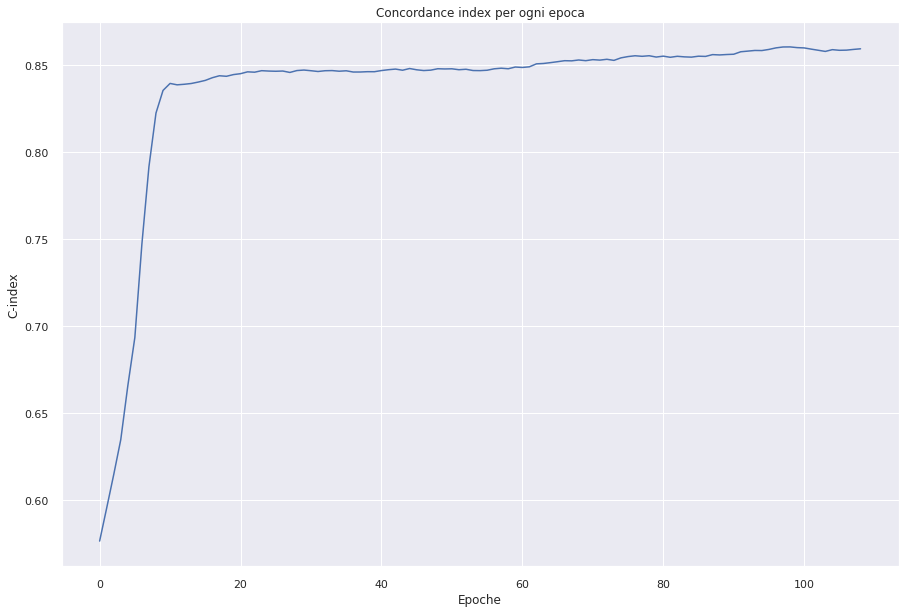

In [30]:
import seaborn as sns

sns.set(rc={'figure.figsize':(15,10)})
sns.lineplot(np.arange(len(ct)),ct )
plt.xlabel('Epoche')
plt.ylabel('C-index')
plt.title('Concordance index per ogni epoca')
plt.savefig('Epoc.png')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


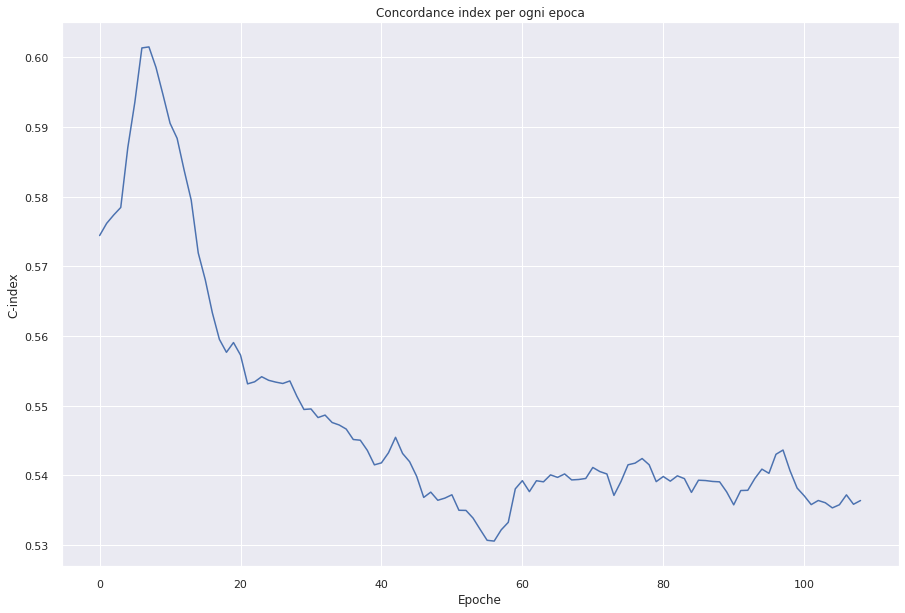

In [31]:
import seaborn as sns

sns.set(rc={'figure.figsize':(15,10)})
sns.lineplot(np.arange(len(c)),c )
plt.xlabel('Epoche')
plt.ylabel('C-index')
plt.title('Concordance index per ogni epoca')
plt.savefig('Epoc.png')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

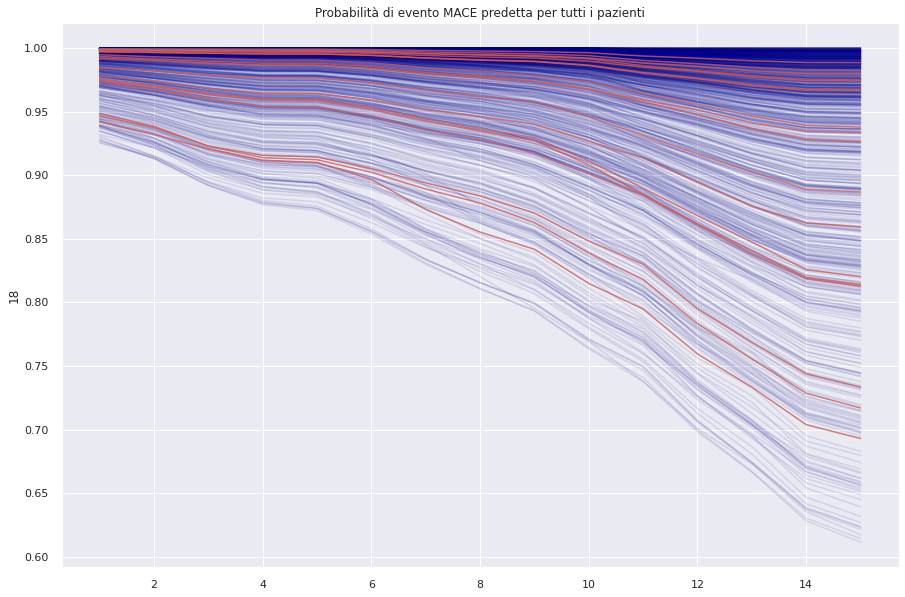

In [32]:
label = labelte
sum(label)
p = model.predict( datate)

p.shape
cind = []
risk = np.zeros(shape=(903  ,15))
for t, t_time in enumerate(np.arange(1,16,1)):
  eval_horizon = int(t_time)
  risk[:,t] = np.reshape(np.sum(p[:,:,:(eval_horizon+1)], axis=2), 903  )

risk = pd.DataFrame(risk)
sns.set(rc={'figure.figsize':(15,10)})
for i in range(903 ):
  if label[i] == 0:
    sns.lineplot(np.arange(1,16,1),1-risk.loc[i,:] , alpha = .1, color = 'darkblue')


for i in range(903  ):
  if label[i] == 1:
    sns.lineplot(np.arange(1,16,1),1-risk.loc[i,:] , alpha = .8, color = 'indianred')
plt.title('Probabilità di evento MACE predetta per tutti i pazienti')  
plt.savefig('sop_pred.png')

In [33]:
cind = []
risk = np.zeros(shape=(903  ,15))
p = model.predict(datate)
for t, t_time in enumerate(np.arange(3,16,1)):
  eval_horizon = int(t_time)
  risk[:,t] = np.reshape(np.sum(p[:,:,:(eval_horizon+1)], axis=2), 903  )


  cind.append(c_index(risk[:,t], timete, (labelte[:,0] == 1).astype(int), eval_horizon) )  
cind_m = np.mean(np.array(cind))
cind_m

0.6188912005977005

In [34]:
pip install shap


     |████████████████████████████████| 564 kB 8.2 MB/s 


In [35]:
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import tree

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [36]:
def pred(data):
  risk = model.predict(data)
  return risk[:,0,12]

rf_shap_values = shap.KernelExplainer(pred, shap.kmeans(data,25))


In [37]:
shap_val = rf_shap_values.shap_values(data ,nsamples=25 )

  0%|          | 0/3609 [00:00<?, ?it/s]

In [38]:
shap.initjs()
bin_list           = [ 'anno_inizio_ARV' , 'HCV' ]
cont_list          = [ 'AGE_UPD' , 'PLT' , 'ipert_si_no', 'NRTI_time_exp'  , 'NNRTI_time_exp' ]
feat_list          = cont_list + bin_list
feat_list          = cont_list + bin_list
data,data_mi,t = DATA
shap.force_plot(rf_shap_values.expected_value, shap_val , data, link='logit' , feature_names= feat_list )

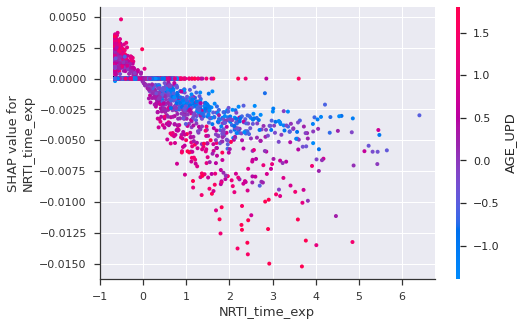

In [39]:
bin_list           = [ 'anno_inizio_ARV' , 'HCV' ]
cont_list          = [ 'AGE_UPD' , 'PLT' , 'ipert_si_no', 'NRTI_time_exp'  , 'NNRTI_time_exp' ]
feat_list          = cont_list + bin_list
shap.dependence_plot(3,shap_val, data , interaction_index=0, feature_names =feat_list )


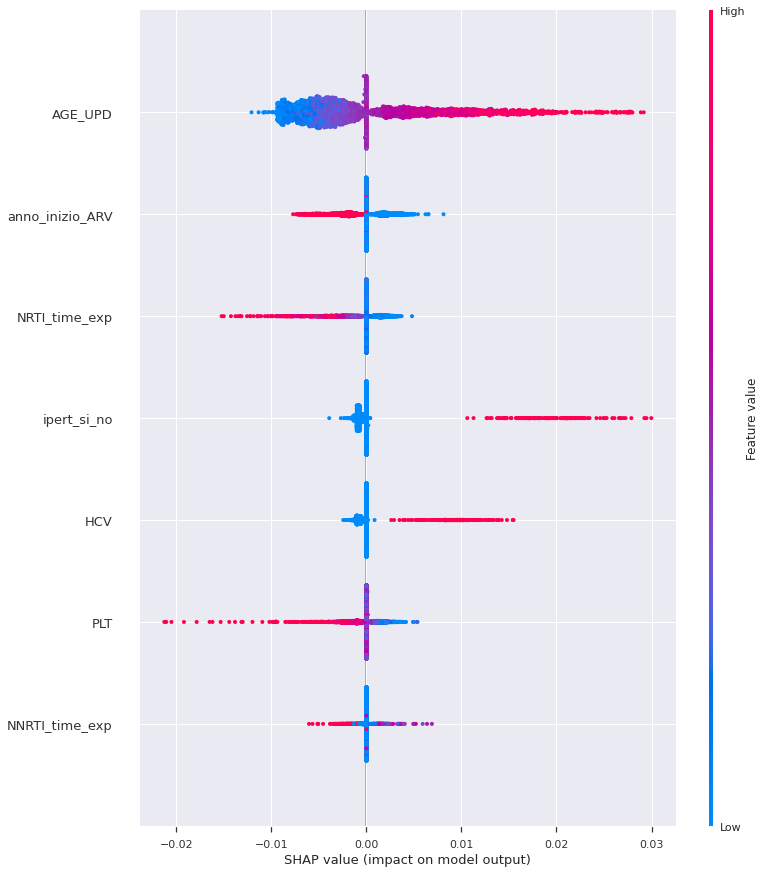

In [40]:
bin_list           = [ 'anno_inizio_ARV' , 'HCV' ]
cont_list          = [ 'AGE_UPD' , 'PLT' , 'ipert_si_no', 'NRTI_time_exp'  , 'NNRTI_time_exp' ]
feat_list          = cont_list + bin_list
feat_list          = cont_list + bin_list       
feat_list          = cont_list + bin_list
from matplotlib.pyplot import figure

figure(figsize=(12, 18))
shap.summary_plot(shap_val, features=data, feature_names=feat_list, plot_size=(12,15),  )

In [41]:
import pandas as pd
import seaborn as sns
feat_list = ['Exposure time to NNRTIs' , 'Exposure time to PIs' , 'Hepatitis C' , 'Platelets' , 'Beginning year of ART', 'Exposure time to INIs' , 'Age' ,
             'Hypertension' , ' Exposure time to NRTIs']
vals = [0.22 , 0.19 , 0.183 , 0.145 , 0.1364 , 0.108 , 0.102 , 0.095 , 0.0652]
feature_importance = pd.DataFrame(list(zip(feat_list, vals)),
                                  columns=['Variables','Feature importance'])
feature_importance.sort_values(by=['Feature importance'],
                               ascending=False, inplace=True)


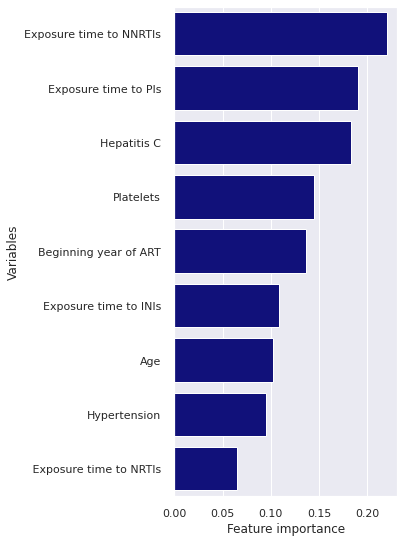

In [42]:
sns.set(rc={'figure.figsize':(4,9)})

sns.barplot(y = 'Variables',x = 'Feature importance',data=feature_importance, orient = 'h' , color="darkblue" )

In [43]:
vals = np.abs(shap_val).mean(0)


feature_importance = pd.DataFrame(list(zip(feat_list, vals)),
                                  columns=['Variables','Feature importance'])
feature_importance.sort_values(by=['Feature importance'],
                               ascending=False, inplace=True)


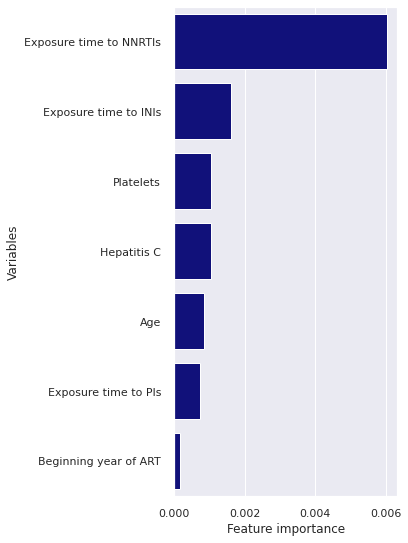

In [44]:
sns.set(rc={'figure.figsize':(4,9)})

sns.barplot(y = 'Variables',x = 'Feature importance',data=feature_importance, orient = 'h' , color="darkblue" )

## Bootstrap and jitterin

In [45]:
label = labelte
sum(label)
p = model.predict( datate )

p.shape
cind = []
risk = np.zeros(shape=(903  ,3000))
for t, t_time in enumerate(np.linspace(1,15,3000 )):
  eval_horizon = int(t_time)
  risk[:,t] = np.reshape(np.sum(p[:,:,:(eval_horizon+1)], axis=2), 903  )

risk = pd.DataFrame(risk)


In [46]:
time_pred = np.zeros(903)
t = np.linspace(0,15,3000)
for k in range(903):
  if sum((risk.loc[k,:]>0.02))>0:
    time_pred[k] = t[(risk.loc[k,:]>0.02)][0]
  else:
    time_pred[k] = 15


In [47]:
time_true = timete
MSE_e = np.mean(np.square(time_true[np.reshape(labelte , 903) == 1]-time_pred[np.reshape(labelte , 903) == 1]))
MSE_a = np.mean(np.square(time_true[np.reshape(timete , 903) <= 15]-time_pred[np.reshape(timete , 903) <= 15]))
cnt = 0
for i in range(903):
  if time_true[i] <= 15:
    if time_true[i] < time_pred[i]:
      cnt +=1
perc = cnt/sum(time_true <= 15)    

In [48]:
sum(labelte)

array([18])

In [49]:
print(MSE_e)
print(MSE_a)
print(perc)



44.09992913273175
54.58329863541682
[0.58956276]


In [50]:
lab_pred = time_pred != 15.

In [51]:
TP = sum(np.diag(np.multiply(lab_pred,labelte)))
TN = sum(np.diag(labelte+lab_pred) == 0)
FP = sum(lab_pred) - TP
FN = sum(lab_pred==False) - TN
print("sens:"  + str(TP / (TP+FN)))
print("acc:" + str((TP+TN)/(TP+TN+FP+FN)))

print("sec:" + str((TN)/(TN+FP)))
print(str(TP)+"|"+str(FN))
print(str(FP)+"|"+str(TN))


sens:0.8888888888888888
acc:0.3964562569213732
sec:0.3864406779661017
16|2
543|342


In [52]:
(datate, timete, labelte)  = DATA
p = model.predict( data)
model.x_dim
p.shape
 
cind = []
risk = np.zeros(shape=(3609  ,15))
for t, t_time in enumerate(np.arange(3,16,3)):
  eval_horizon = int(t_time)
  risk[:,t] = np.reshape(np.sum(p[:,:,:(eval_horizon+1)], axis=2), 3609  )


  cind.append(c_index(risk[:,t], timete, (labelte[:,0] == 1).astype(int), eval_horizon) )   
cind_m = np.mean(np.array(cind[3:14]))
cind_m


0.8117719961472207

In [53]:
from lifelines.utils import concordance_index

DIM, DATA, MASK = import_dataset_METABRIC_mod()
(datate, timete, labelte) 
p = model.predict( datate)

p.shape
cind = []
risk = np.zeros(shape=(3609   ,15))
for t, t_time in enumerate(np.arange(1,16,1)):
  eval_horizon = int(t_time)
  risk[:,t] = np.reshape(np.sum(p[:,:,:(eval_horizon+1)], axis=2), 3609   )


  cind.append(c_index(risk[:,t], timete, (labelte[:,0] == 1).astype(int), eval_horizon) )   
cind_m = np.mean(np.array(cind))
cind

[0.9133469526727954,
 0.9156626506024096,
 0.9028184804201168,
 0.9034839568552108,
 0.9018485005170631,
 0.9009953464322648,
 0.8761653218134814,
 0.8525507038892866,
 0.8307320583088307,
 0.8224114566777642,
 0.8225739499415781,
 0.8126292063856667,
 0.8153734699317235,
 0.8079109190626558,
 0.8109147859087749]

In [54]:
cind = []
risk = np.zeros(shape=(3609  ,15))
p = model.predict(data)
for t, t_time in enumerate(np.arange(3,16,1)):
  eval_horizon = int(t_time)
  risk[:,t] = np.reshape(np.sum(p[:,:,:(eval_horizon+1)], axis=2), 3609  )


  cind.append(c_index(risk[:,t], timete, (labelte[:,0] == 1).astype(int), eval_horizon) )  
cind_m = np.mean(np.array(cind))
cind_m

0.8508006273957243

In [55]:
def import_dataset_METABRIC_mod_shuffle(col,norm_mode='standard' ):
    in_filename1 = '/content/dataset_completo_modelli_train_bl.txt'
    
    df1 = pd.read_csv(in_filename1, sep =',')
    df1['time_CVD1'] = np.float32(np.where( df1['time_CVD1'] == 'non evento' , 0 , df1['time_CVD1']))

    df1[['SESSO']] = np.where(df1[['SESSO']]=='F',1,0) 
    df1[['anno_inizio_ARV']] = np.where(df1[['anno_inizio_ARV']]=='<=2007',1,0) 
    df1[['FDRn']] = np.where(df1[['FDRn']]=='MSM',1,0)
    df1[['HCV']] = np.float32(np.where(df1[['HCV']]=='non noto',0,df1[['HCV']]))
    df1[['HBV']] = np.float32(np.where(df1[['HBV']]=='non noto',0,df1[['HBV']]))

    bin_list           = [ 'anno_inizio_ARV' , 'HCV' ]
    cont_list          = [ 'AGE_UPD' , 'PLT' , 'ipert_si_no', 'NRTI_time_exp'  , 'NNRTI_time_exp' ]
    feat_list          = cont_list + bin_list
    df1[col] = np.random.permutation(df1[col])

    df1[['time']] = np.where(df1[['ID_CVD']] == 1 , df1[['time_CVD1']] , df1[['end']])
    df1[['label']] = df1[['ID_CVD']]
    df2 = df1.loc[:,['label','time']]
    df1 = df1.loc[:,feat_list]
    data  = np.asarray(df1)
    data  = f_get_Normalization(data, norm_mode)  
    time  = np.asarray(df2[['time']])
    # time  = np.round(time/12.) #unit time = month
    label = np.asarray(df2[['label']])

    
    num_Category    = int(np.max(time) * 1.2)        #to have enough time-horizon
    num_Event       = int(len(np.unique(label)) - 1) #only count the number of events (do not count censoring as an event)

    x_dim           = np.shape(data)[1]

    mask1           = f_get_fc_mask2(time, label, num_Event, num_Category)
    mask2           = f_get_fc_mask3(time, -1, num_Category)

    DIM             = (x_dim)
    DATA            = (data, time, label)
    MASK            = (mask1, mask2)

    return DIM, DATA, MASK

DIM_imp, DATA_imp , MASK_imp = import_dataset_METABRIC_mod_shuffle('AGE_UPD')
(data_imp, time_imp, label_imp)  = DATA_imp

p = model.predict( data_imp)
p.shape
cind = []
risk = np.zeros(shape=(3609   ,15))
for t, t_time in enumerate(np.arange(1,16,1)):
  eval_horizon = int(t_time)
  risk[:,t] = np.reshape(np.sum(p[:,:,:(eval_horizon+1)], axis=2), 3609)


  cind.append(c_index(risk[:,t], time_imp, (label_imp[:,0] == 1).astype(int), eval_horizon) )  
cind_age = np.mean(np.array(cind))
cind

KeyError: ignored

In [ ]:
DIM_imp, DATA_imp , MASK_imp = import_dataset_METABRIC_mod_shuffle('VIREMIA')
(data_imp, time_imp, label_imp)  = DATA_imp

p = model.predict( data_imp)
p.shape
cind = []
risk = np.zeros(shape=(3609   ,15))
for t, t_time in enumerate(np.arange(1,16,1)):
  eval_horizon = int(t_time)
  risk[:,t] = np.reshape(np.sum(p[:,:,:(eval_horizon+1)], axis=2), 3609   )


  cind.append(c_index(risk[:,t], time_imp, (label_imp[:,0] == 1).astype(int), eval_horizon) )   
cind_vir = np.mean(np.array(cind))
cind

In [ ]:
DIM_imp, DATA_imp , MASK_imp = import_dataset_METABRIC_mod_shuffle('CD4')
(data_imp, time_imp, label_imp)  = DATA_imp


p = model.predict( data_imp)
p.shape
cind = []
risk = np.zeros(shape=(3609   ,15))
for t, t_time in enumerate(np.arange(1,16,1)):
  eval_horizon = int(t_time)
  risk[:,t] = np.reshape(np.sum(p[:,:,:(eval_horizon+1)], axis=2), 3609   )


  cind.append(c_index(risk[:,t], time_imp, (label_imp[:,0] == 1).astype(int), eval_horizon) )   
cind_cd = np.mean(np.array(cind))
cind

In [ ]:
DIM_imp, DATA_imp , MASK_imp = import_dataset_METABRIC_mod_shuffle('HCV')
(data_imp, time_imp, label_imp)  = DATA_imp

p = model.predict( data_imp)
p.shape
cind = []
risk = np.zeros(shape=(3609   ,15))
for t, t_time in enumerate(np.arange(1,16,1)):
  eval_horizon = int(t_time)
  risk[:,t] = np.reshape(np.sum(p[:,:,:(eval_horizon+1)], axis=2), 3609   )


  cind.append(c_index(risk[:,t], time_imp, (label_imp[:,0] == 1).astype(int), eval_horizon) )   
cind_HCV = np.mean(np.array(cind))
cind

In [ ]:
DIM_imp, DATA_imp , MASK_imp = import_dataset_METABRIC_mod_shuffle('PLT')
(data_imp, time_imp, label_imp)  = DATA_imp


p = model.predict( data_imp)
p.shape
cind = []
risk = np.zeros(shape=(3609   ,15))
for t, t_time in enumerate(np.arange(1,16,1)):
  eval_horizon = int(t_time)
  risk[:,t] = np.reshape(np.sum(p[:,:,:(eval_horizon+1)], axis=2), 3609   )


  cind.append(c_index(risk[:,t], time_imp, (label_imp[:,0] == 1).astype(int), eval_horizon) )   
cind_plt = np.mean(np.array(cind))
cind

In [ ]:
DIM_imp, DATA_imp , MASK_imp = import_dataset_METABRIC_mod_shuffle('PI_time_exp')
(data_imp, time_imp, label_imp)  = DATA_imp


p = model.predict( data_imp)
p.shape
cind = []
risk = np.zeros(shape=(3609   ,15))
for t, t_time in enumerate(np.arange(1,16,1)):
  eval_horizon = int(t_time)
  risk[:,t] = np.reshape(np.sum(p[:,:,:(eval_horizon+1)], axis=2), 3609   )


  cind.append(c_index(risk[:,t], time_imp, (label_imp[:,0] == 1).astype(int), eval_horizon) )   
cind_PI_time_exp = np.mean(np.array(cind))
cind

In [ ]:
DIM_imp, DATA_imp , MASK_imp = import_dataset_METABRIC_mod_shuffle('NRTI_time_exp')
(data_imp, time_imp, label_imp)  = DATA_imp


p = model.predict( data_imp)
p.shape
cind = []
risk = np.zeros(shape=(3609   ,15))
for t, t_time in enumerate(np.arange(1,16,1)):
  eval_horizon = int(t_time)
  risk[:,t] = np.reshape(np.sum(p[:,:,:(eval_horizon+1)], axis=2), 3609   )


  cind.append(c_index(risk[:,t], time_imp, (label_imp[:,0] == 1).astype(int), eval_horizon) )   
cind_NRTI_time_exp = np.mean(np.array(cind))
cind

In [ ]:
DIM_imp, DATA_imp , MASK_imp = import_dataset_METABRIC_mod_shuffle('NNRTI_time_exp')
(data_imp, time_imp, label_imp)  = DATA_imp


p = model.predict( data_imp)
p.shape
cind = []
risk = np.zeros(shape=(3609   ,15))
for t, t_time in enumerate(np.arange(1,16,1)):
  eval_horizon = int(t_time)
  risk[:,t] = np.reshape(np.sum(p[:,:,:(eval_horizon+1)], axis=2), 3609   )


  cind.append(c_index(risk[:,t], time_imp, (label_imp[:,0] == 1).astype(int), eval_horizon) )   
cind_NRTTI_time_exp = np.mean(np.array(cind))
cind

In [ ]:
DIM_imp, DATA_imp , MASK_imp = import_dataset_METABRIC_mod_shuffle('RAZZA')
(data_imp, time_imp, label_imp)  = DATA_imp


p = model.predict( data_imp)
p.shape
cind = []
risk = np.zeros(shape=(3609   ,15))
for t, t_time in enumerate(np.arange(1,16,1)):
  eval_horizon = int(t_time)
  risk[:,t] = np.reshape(np.sum(p[:,:,:(eval_horizon+1)], axis=2), 3609   )


  cind.append(c_index(risk[:,t], time_imp, (label_imp[:,0] == 1).astype(int), eval_horizon) )   
cind_RAZZA = np.mean(np.array(cind))
cind

In [ ]:
DIM_imp, DATA_imp , MASK_imp = import_dataset_METABRIC_mod_shuffle('anno_inizio_ARV')
(data_imp, time_imp, label_imp)  = DATA_imp


p = model.predict( data_imp)
p.shape
cind = []
risk = np.zeros(shape=(3609   ,15))
for t, t_time in enumerate(np.arange(1,16,1)):
  eval_horizon = int(t_time)
  risk[:,t] = np.reshape(np.sum(p[:,:,:(eval_horizon+1)], axis=2), 3609   )


  cind.append(c_index(risk[:,t], time_imp, (label_imp[:,0] == 1).astype(int), eval_horizon) )   
cind_anno_inizio_ARV = np.mean(np.array(cind))
cind

In [ ]:
DIM_imp, DATA_imp , MASK_imp = import_dataset_METABRIC_mod()
(data_imp, time_imp, label_imp)  = DATA_imp


p = model.predict( data_imp)
p.shape
cind = []
risk = np.zeros(shape=(3609   ,15))
for t, t_time in enumerate(np.arange(1,16,1)):
  eval_horizon = int(t_time)
  risk[:,t] = np.reshape(np.sum(p[:,:,:(eval_horizon+1)], axis=2), 3609   )


  cind.append(c_index(risk[:,t], time_imp, (label_imp[:,0] == 1).astype(int), eval_horizon) )   
cind_m = np.mean(np.array(cind))
cind

In [ ]:
bin_list           = [ 'anno_inizio_ARV' , 'HCV' ]
cont_list          = [ 'AGE_UPD' , 'PLT', 'VIREMIA' , 'PI_time_exp' , 'NRTI_time_exp'  , 'NNRTI_time_exp' ]

In [ ]:
sns.set(rc={'figure.figsize':(15,10)})

bin_list           = [ 'anno_inizio_ARV' , 'HCV' ]
cont_list          = [ 'AGE_UPD' , 'PLT', 'VIREMIA' , 'PI_time_exp' , 'NRTI_time_exp'  , 'NNRTI_time_exp' ]
d = pd.DataFrame({'Variables':['AGE_UPD' , 'PLT', 'VIREMIA' , 'PI_time_exp' , 'NRTI_time_exp'  , 'NNRTI_time_exp' , 'anno_inizio_ARV' , 'HCV' ], 
                  'Feature importance':[cind_m-cind_age , cind_m-cind_plt ,cind_m-cind_vir,
                            cind_m-cind_PI_time_exp , cind_m-cind_NRTI_time_exp , cind_m-cind_NRTTI_time_exp , 
                            cind_m-cind_anno_inizio_ARV, cind_m-cind_HCV ]/cind_m})
d.sort_values(by=['Feature importance'],
                               ascending=False, inplace=True)
sns.barplot(y= 'Variables', x = 'Feature importance',data=d ,orient='h', color = 'darkblue')
plt.savefig('feature_imp1.png')

# Dynamic DeepHit

In [ ]:
print('ok')

In [ ]:
pip install shap


In [ ]:
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import tree

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def pred(data):
  risk = model.predict(data)
  return risk[:,0,12]

rf_shap_values = shap.KernelExplainer(pred, shap.sample(datate, nsamples = 10))


In [ ]:
shap_val = rf_shap_values.shap_values(datate ,nsamples=10 )